In [2]:
import os
import requests
import zipfile
import shutil
from collections import defaultdict

import gdown
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Download data

In [ ]:
zip_url = 'https://drive.google.com/file/d/1FcWrBIg63MwV26DE0882baBarakUb3HA/view?usp=sharing'
zip_path = '/content/data.zip'

root_folder = ''

In [ ]:
def get_file_id(url):
    return url.split('d/')[1].split('/')[0]

In [ ]:
def download_data(url, path_to_save, update=False):
    if os.path.exists(path_to_save):
        print(f"The file '{path_to_save}' exists")
        if update:
            os.remove(path_to_save)
            print("Deleted it")
        else:
            print('No need to delete')
            return None

    file_id = get_file_id(url)
    file_url = f'https://drive.google.com/uc?id={file_id}'

    gdown.download(file_url, output=path_to_save, quiet=False)

    print(f'File {path_to_save} downloaded. Size = { round(os.path.getsize(path_to_save) / (1024 * 1024)) }')


In [ ]:
def delete_folder(folder_path):
    if os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' and all its contents have been removed.")
    else:
        print(f"The folder '{folder_path}' does not exist.")

In [ ]:
def extract_data(file_path):
    extracted_files = 0
    r_folder = ''

    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_content = zip_ref.namelist()
        r_folder = zip_content[0]
        delete_folder(r_folder)

        for fname in tqdm(zip_content):
            if '.DS_Store' in fname or '__MACOSX' in fname:
                continue

            zip_ref.extract(fname)
            extracted_files += 1

        print(f"Extracted {extracted_files} files to {r_folder}")
        return r_folder

In [ ]:
download_data(zip_url, zip_path)

Downloading...
From (original): https://drive.google.com/uc?id=1FcWrBIg63MwV26DE0882baBarakUb3HA
From (redirected): https://drive.google.com/uc?id=1FcWrBIg63MwV26DE0882baBarakUb3HA&confirm=t&uuid=05ab2735-1f8a-4bb7-b8ac-9a37c2bcef93
To: /content/data.zip
100%|██████████| 1.24G/1.24G [00:19<00:00, 63.3MB/s]

File /content/data.zip downloaded. Size = 1183


In [ ]:
root_folder = extract_data(zip_path)

if root_folder.endswith('/'):
    root_folder = root_folder[0:-1]

root_folder = '/content/' + 'DSL_Winter_Project_2025'

The folder 'DSL_Winter_Project_2025/' does not exist.


  0%|          | 0/3635 [00:00<?, ?it/s]

Extracted 3630 files to DSL_Winter_Project_2025/


In [ ]:
if os.path.exists(zip_path):
    os.remove(zip_path)

# Data preparation

- **Sampling rate**: The sampling rate of the audio signal, in Hz  
- **Age**: The chronological age of the speaker (target label)  
- **Gender**: The gender of the speaker  
- **Ethnicity**: The ethnicity of the speaker  
- **Mean pitch, Max pitch, Min pitch**: Mean, maximum, and minimum pitch of the speech signal, in Hz  
- **Jitter**: A measure of the variations in pitch, representing voice stability  
- **Shimmer**: A measure of amplitude variations in the speech signal  
- **Energy**: The overall energy of the speech signal  
- **ZCR mean**: The mean zero-crossing rate, indicating the number of times the signal changes sign  
- **Spectral centroid mean**: The mean spectral centroid, representing the “center of mass” of the frequency spectrum  
- **Tempo**: The estimated speaking rate, in beats per minute (BPM)  
- **HNR**: The harmonic-to-noise ratio, indicating voice quality  
- **Num words, Num characters**: The number of words and characters in the spoken sentence  
- **Num pauses**: The number of pauses detected in the speech  
- **Silence duration**: The total duration of silence within the speech signal, in seconds  
- **Path**: The file path to the audio recording

In [ ]:
df = pd.read_csv(f"{root_folder}/development.csv")
df

Id  sampling_rate   age  gender   ethnicity  mean_pitch  max_pitch  \
0        0          22050  24.0  female      arabic  1821.69060  3999.7170   
1        1          22050  22.5  female   hungarian  1297.81870  3998.8590   
2        2          22050  22.0  female  portuguese  1332.85240  3998.8025   
3        3          22050  22.0  female     english  1430.34990  3998.4510   
4        4          22050  22.0    male       dutch  1688.72340  3998.6113   
...    ...            ...   ...     ...         ...         ...        ...   
2928  2928          22050  24.0    male     english  1641.14930  3999.1616   
2929  2929          22050  15.0  female        igbo  1089.60050  3984.6550   
2930  2930          22050  17.0  female        igbo   994.46484  3989.1785   
2931  2931          22050  18.0    male      arabic  1600.00820  3999.7559   
2932  2932          22050  18.0  female        igbo   690.28046  3988.2874   

      min_pitch    jitter   shimmer    energy  zcr_mean  \
0     145.43066  0.013795  0.082725  0.002254  0.210093   
1     145.37268  0.025349  0.096242  0.007819  0.078849   
2     145.42395  0.019067  0.119456  0.002974  0.105365   
3     147.98083  0.017004  0.102389  0.022371  0.173701   
4     145.44772  0.028027  0.124831  0.005369  0.107279   
...         ...       ...       ...       ...       ...   
2928  145.39359  0.023647  0.115361  0.001879  0.111799   
2929  145.58409  0.015317  0.126740  0.000339  0.070508   
2930  148.97475  0.009677  0.103535  0.001464  0.058442   
2931  145.36101  0.019571  0.100946  0.004451  0.115139   
2932  149.26643  0.014833  0.096168  0.003675  0.042133   

      spectral_centroid_mean           tempo         hnr  num_words  \
0                3112.257251  [151.99908088] -123.999726         69   
1                1688.016389  [129.19921875]  -86.928478         69   
2                2576.901706  [117.45383523]  -98.450670         69   
3                3269.751413  [117.45383523]  -56.459762         69   
4                1930.897375  [112.34714674]  -80.349204         69   
...                      ...             ...         ...        ...   
2928             2188.853478   [184.5703125] -100.921055         69   
2929             2712.362323   [83.35433468]    6.757283          0   
2930             2248.698477   [89.10290948]  -53.913449          1   
2931             1834.596924   [143.5546875]  -96.143090         69   
2932             1440.227098   [83.35433468]  -89.464755          0   

      num_characters  num_pauses  silence_duration  \
0                281          39         23.846893   
1                281          21         19.388662   
2                281           1         21.640998   
3                281           9         19.644127   
4                281          11         18.041905   
...              ...         ...               ...   
2928             281          11         17.461406   
2929               0           1          1.509206   
2930               9           1          1.645034   
2931             281          19         16.346848   
2932               0           4          2.275556   

                             path  
0        audios_development/1.wav  
1        audios_development/2.wav  
2        audios_development/3.wav  
3        audios_development/4.wav  
4        audios_development/5.wav  
...                           ...  
2928  audios_development/2929.wav  
2929  audios_development/2930.wav  
2930  audios_development/2931.wav  
2931  audios_development/2932.wav  
2932  audios_development/2933.wav  

[2933 rows x 20 columns]

In [ ]:
df.describe()

Id  sampling_rate          age   mean_pitch    max_pitch  \
count  2933.000000         2933.0  2933.000000  2933.000000  2933.000000   
mean   1466.000000        22050.0    27.897886  1189.536569  3779.570485   
std     846.828495            0.0    13.093316   414.193673   532.847869   
min       0.000000        22050.0     6.000000   346.974330   935.515560   
25%     733.000000        22050.0    19.000000   818.922360  3948.234400   
50%    1466.000000        22050.0    23.000000  1208.998300  3998.397200   
75%    2199.000000        22050.0    32.000000  1523.777700  3999.485400   
max    2932.000000        22050.0    97.000000  2724.892800  3999.792500   

         min_pitch       jitter      shimmer       energy     zcr_mean  \
count  2933.000000  2933.000000  2933.000000  2933.000000  2933.000000   
mean    146.934930     0.021190     0.107741     0.005208     0.104774   
std       3.757917     0.006626     0.029005     0.006074     0.051646   
min     145.349140     0.007292     0.045205     0.000028     0.015947   
25%     145.419140     0.016734     0.087378     0.001960     0.060733   
50%     145.622010     0.020525     0.104697     0.003716     0.098964   
75%     146.820890     0.024558     0.124993     0.006338     0.139559   
max     202.040700     0.096153     0.265167     0.129114     0.335976   

       spectral_centroid_mean          hnr    num_words  num_characters  \
count             2933.000000  2933.000000  2933.000000     2933.000000   
mean              2176.369847   -74.526288    41.307535      167.936243   
std                578.925294    38.446856    32.782431      133.816974   
min                692.116731  -193.693345     0.000000        0.000000   
25%               1740.756716  -104.555692     4.000000       14.000000   
50%               2150.814043   -84.415550    69.000000      281.000000   
75%               2566.190670   -40.339359    69.000000      281.000000   
max               4144.132595    12.403661    69.000000      281.000000   

        num_pauses  silence_duration  
count  2933.000000       2933.000000  
mean     12.423116         13.501159  
std      14.273205         10.839142  
min       1.000000          0.668345  
25%       1.000000          1.732925  
50%       8.000000         17.368526  
75%      20.000000         21.408798  
max      97.000000         83.777596

In [ ]:
dfev = pd.read_csv(f"{root_folder}/evaluation.csv")
dfev

Id  sampling_rate  gender ethnicity  mean_pitch  max_pitch  min_pitch  \
0      0          22050    male   spanish  1056.91740  3945.1610  145.38750   
1      1          22050    male     xiang  1231.84570  3999.1720  145.56432   
2      2          22050    male      igbo   958.29065  3445.4490  145.67374   
3      3          22050  female   spanish  1396.54170  3998.8948  145.41223   
4      4          22050    male   spanish  1633.86770  3999.7632  145.36313   
..   ...            ...     ...       ...         ...        ...        ...   
686  686          22050    male      igbo   570.62740  3900.6730  145.67577   
687  687          22050    male      igbo   974.13965  3919.0024  145.90408   
688  688          22050  female   serbian  1113.27650  3999.3510  145.38307   
689  689          22050    male   spanish  1759.17420  3999.4610  145.56773   
690  690          22050    male      igbo   779.53890  3972.4630  147.44424   

       jitter   shimmer    energy  zcr_mean  spectral_centroid_mean  \
0    0.022082  0.171076  0.003136  0.032963             1549.607050   
1    0.026571  0.132585  0.006783  0.123895             2344.817369   
2    0.018044  0.096289  0.004478  0.089149             1939.574896   
3    0.027290  0.088901  0.014893  0.097054             1832.059113   
4    0.021621  0.103855  0.001369  0.140950             2534.611168   
..        ...       ...       ...       ...                     ...   
686  0.018842  0.079197  0.004545  0.072083             1946.502158   
687  0.024367  0.117492  0.000878  0.076900             3319.620800   
688  0.020637  0.089355  0.009148  0.095613             1973.127197   
689  0.026118  0.106429  0.003707  0.141474             2137.517812   
690  0.010952  0.108114  0.003370  0.083540             2530.285199   

              tempo         hnr  num_words  num_characters  num_pauses  \
0     [80.74951172] -116.662338         69             281           2   
1     [89.10290948]  -78.253824         69             281          27   
2      [123.046875]  -71.630742          6              22           2   
3      [123.046875] -101.533013         69             281          31   
4    [112.34714674] -134.914070         69             281          35   
..              ...         ...        ...             ...         ...   
686  [112.34714674]  -42.895295          6              15           1   
687  [112.34714674] -144.881089          7              22           1   
688  [112.34714674]  -73.559944         69             281          15   
689  [117.45383523]  -93.562873         69             281          10   
690   [184.5703125]  -35.776665          5              19           1   

     silence_duration                       path  
0           38.198503    audios_evaluation/1.wav  
1           29.605442    audios_evaluation/2.wav  
2            2.275556    audios_evaluation/3.wav  
3           22.151837    audios_evaluation/4.wav  
4           22.430476    audios_evaluation/5.wav  
..                ...                        ...  
686          1.861950  audios_evaluation/687.wav  
687          4.876190  audios_evaluation/688.wav  
688         25.541950  audios_evaluation/689.wav  
689         20.967619  audios_evaluation/690.wav  
690          1.230658  audios_evaluation/691.wav  

[691 rows x 19 columns]

In [ ]:
dfev.describe()

Id  sampling_rate   mean_pitch    max_pitch   min_pitch  \
count  691.000000          691.0   691.000000   691.000000  691.000000   
mean   345.000000        22050.0  1191.041077  3832.214580  146.591685   
std    199.618803            0.0   379.826928   451.201809    3.212186   
min      0.000000        22050.0   419.396150  1151.012200  145.349230   
25%    172.500000        22050.0   865.617580  3955.649050  145.401825   
50%    345.000000        22050.0  1209.680400  3998.631300  145.529140   
75%    517.500000        22050.0  1487.326050  3999.521850  146.396920   
max    690.000000        22050.0  2201.411000  3999.790800  186.688950   

           jitter     shimmer      energy    zcr_mean  spectral_centroid_mean  \
count  691.000000  691.000000  691.000000  691.000000              691.000000   
mean     0.021320    0.110438    0.005074    0.105111             2214.701841   
std      0.006399    0.029365    0.005430    0.050162              571.250581   
min      0.009395    0.035001    0.000056    0.018496              803.534172   
25%      0.017184    0.089501    0.001851    0.064549             1785.536118   
50%      0.020670    0.106233    0.003582    0.098416             2174.406614   
75%      0.024536    0.126537    0.006147    0.135834             2580.589333   
max      0.077450    0.246068    0.048074    0.335676             4753.076563   

              hnr   num_words  num_characters  num_pauses  silence_duration  
count  691.000000  691.000000      691.000000  691.000000        691.000000  
mean   -84.551539   43.946454      178.522431   15.698987         14.982523  
std     36.514264   32.019084      130.933540   16.957466         11.040405  
min   -155.826124    0.000000        0.000000    1.000000          0.925669  
25%   -112.362377    5.000000       17.000000    1.000000          2.115329  
50%    -92.686476   69.000000      281.000000   11.000000         18.552744  
75%    -59.687405   69.000000      281.000000   26.000000         23.010975  
max     11.653742   69.000000      281.000000   76.000000         57.663855

## Columns

In [ ]:
color_map = {'female' : 'pink', 'male' : 'blue'}

In [ ]:
def yrange(serdata):
    maxv = serdata.max()
    minv = serdata.min()
    return int(minv - minv % 5), int(maxv + (5 - maxv % 5))

In [ ]:
def plot_age_dist(dfc: pd.DataFrame, cat_lim = 1, cat_name=None):
    fig, axs = plt.subplots(cat_lim, 2, figsize=(5, cat_lim*4))

    for i, g in enumerate(['male', 'female']):
        data_j = dfc[(dfc['gender'] == g)]

        if cat_name:
            ser_cat_names = dfc[cat_name].value_counts().reset_index().head(cat_lim)[cat_name]
            r1, r2 = yrange(dfc[dfc[cat_name].isin(ser_cat_names)]['age'])

            for j, e in enumerate(ser_cat_names):
                data_ij = data_j[ (data_j[cat_name] == e) ]['age']

                sns.boxplot(data=data_ij, ax=axs[j, i])
                axs[j, i].set_yticks(range(r1, r2, 5))
                axs[j, i].set_ylim(r1, r2)
                axs[j, i].set_title(f"{e} - {g}")
                axs[j, i].grid()

        else:
            data_ij = data_j['age']
            r1, r2 = yrange(data_ij)

            sns.boxplot(data=data_ij, ax=axs[i])
            axs[i].set_yticks(range(r1, r2, 5))
            axs[i].set_ylim(r1, r2)
            axs[i].set_title(f"{g}")
            axs[i].grid()

    plt.tight_layout()
    plt.show()

In [ ]:
def cat_encoder(dfc, col_name, addAge=False, return_enc=False):
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_data = encoder.fit_transform(dfc[[col_name]])

    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

    if addAge:
        encoded_df['age'] = dfc['age']

    if return_enc:
        return encoded_df, encoder
    else:
        return encoded_df

In [ ]:
def plot_corr(dfc, mode='head', limit=None, header=None):
    if limit is not None:
        if mode == 'head':
            dfc = dfc.head(limit)
        elif mode =='tail':
            dfc = dfc.tail(limit)
        palette = None
    else:
        palette = 'coolwarm'

    plt.figure(figsize=(10, 6))
    sns.barplot(x=dfc.index, y=dfc.values, palette=palette)
    plt.xticks(rotation=90)
    plt.title(f"Age correlation {header if header is not None else ''}", fontsize=14)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('corr', fontsize=12)
    plt.tight_layout()
    plt.show()

**sampling_rate**

useless col with same values

In [ ]:
if 'sampling_rate' in df.columns:
    df.drop(columns=['sampling_rate'], inplace=True)

**age**

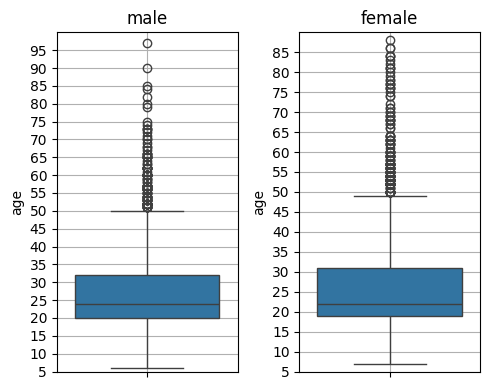

In [ ]:
plot_age_dist(df)

**tempo**

In [ ]:
df['tempo'] = df['tempo'].str.strip("[]").str.split(", ").apply(lambda x: list(map(float, x)))
df['tempo_len'] = df['tempo'].apply(lambda x: len(x))
df.describe()


Id          age   mean_pitch    max_pitch    min_pitch  \
count  2933.000000  2933.000000  2933.000000  2933.000000  2933.000000   
mean   1466.000000    27.897886  1189.536569  3779.570485   146.934930   
std     846.828495    13.093316   414.193673   532.847869     3.757917   
min       0.000000     6.000000   346.974330   935.515560   145.349140   
25%     733.000000    19.000000   818.922360  3948.234400   145.419140   
50%    1466.000000    23.000000  1208.998300  3998.397200   145.622010   
75%    2199.000000    32.000000  1523.777700  3999.485400   146.820890   
max    2932.000000    97.000000  2724.892800  3999.792500   202.040700   

            jitter      shimmer       energy     zcr_mean  \
count  2933.000000  2933.000000  2933.000000  2933.000000   
mean      0.021190     0.107741     0.005208     0.104774   
std       0.006626     0.029005     0.006074     0.051646   
min       0.007292     0.045205     0.000028     0.015947   
25%       0.016734     0.087378     0.001960     0.060733   
50%       0.020525     0.104697     0.003716     0.098964   
75%       0.024558     0.124993     0.006338     0.139559   
max       0.096153     0.265167     0.129114     0.335976   

       spectral_centroid_mean          hnr    num_words  num_characters  \
count             2933.000000  2933.000000  2933.000000     2933.000000   
mean              2176.369847   -74.526288    41.307535      167.936243   
std                578.925294    38.446856    32.782431      133.816974   
min                692.116731  -193.693345     0.000000        0.000000   
25%               1740.756716  -104.555692     4.000000       14.000000   
50%               2150.814043   -84.415550    69.000000      281.000000   
75%               2566.190670   -40.339359    69.000000      281.000000   
max               4144.132595    12.403661    69.000000      281.000000   

        num_pauses  silence_duration  tempo_len  
count  2933.000000       2933.000000     2933.0  
mean     12.423116         13.501159        1.0  
std      14.273205         10.839142        0.0  
min       1.000000          0.668345        1.0  
25%       1.000000          1.732925        1.0  
50%       8.000000         17.368526        1.0  
75%      20.000000         21.408798        1.0  
max      97.000000         83.777596        1.0

In [ ]:
if type(list(df['tempo'])[0]) == list:
    df['tempo'] = df['tempo'].apply(lambda x: x[0])
if 'tempo_len' in df.columns:
    df.drop(columns=['tempo_len'], inplace=True)
df.describe()

Id          age   mean_pitch    max_pitch    min_pitch  \
count  2933.000000  2933.000000  2933.000000  2933.000000  2933.000000   
mean   1466.000000    27.897886  1189.536569  3779.570485   146.934930   
std     846.828495    13.093316   414.193673   532.847869     3.757917   
min       0.000000     6.000000   346.974330   935.515560   145.349140   
25%     733.000000    19.000000   818.922360  3948.234400   145.419140   
50%    1466.000000    23.000000  1208.998300  3998.397200   145.622010   
75%    2199.000000    32.000000  1523.777700  3999.485400   146.820890   
max    2932.000000    97.000000  2724.892800  3999.792500   202.040700   

            jitter      shimmer       energy     zcr_mean  \
count  2933.000000  2933.000000  2933.000000  2933.000000   
mean      0.021190     0.107741     0.005208     0.104774   
std       0.006626     0.029005     0.006074     0.051646   
min       0.007292     0.045205     0.000028     0.015947   
25%       0.016734     0.087378     0.001960     0.060733   
50%       0.020525     0.104697     0.003716     0.098964   
75%       0.024558     0.124993     0.006338     0.139559   
max       0.096153     0.265167     0.129114     0.335976   

       spectral_centroid_mean        tempo          hnr    num_words  \
count             2933.000000  2933.000000  2933.000000  2933.000000   
mean              2176.369847   125.085771   -74.526288    41.307535   
std                578.925294    33.812698    38.446856    32.782431   
min                692.116731    51.679688  -193.693345     0.000000   
25%               1740.756716   103.359375  -104.555692     4.000000   
50%               2150.814043   117.453835   -84.415550    69.000000   
75%               2566.190670   143.554688   -40.339359    69.000000   
max               4144.132595   287.109375    12.403661    69.000000   

       num_characters   num_pauses  silence_duration  
count     2933.000000  2933.000000       2933.000000  
mean       167.936243    12.423116         13.501159  
std        133.816974    14.273205         10.839142  
min          0.000000     1.000000          0.668345  
25%         14.000000     1.000000          1.732925  
50%        281.000000     8.000000         17.368526  
75%        281.000000    20.000000         21.408798  
max        281.000000    97.000000         83.777596

**energy**

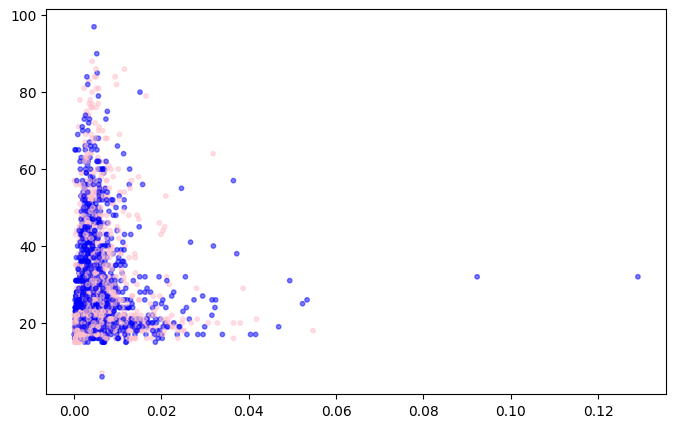

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df['color'] = df['gender'].map(color_map)

plt.scatter(df['energy'], df['age'],alpha=0.5, s=10, c=df['color'])

In [ ]:
df = df[df['energy'] < 0.06].reset_index(drop=True)

**ethnicity**

In [ ]:
pd.merge(df['ethnicity'].value_counts(normalize=True).reset_index(), dfev['ethnicity'].value_counts(normalize=True).reset_index(), on='ethnicity')

ethnicity  proportion_x  proportion_y
0          igbo      0.368134      0.335745
1        urhobo      0.010918      0.001447
2        ibibio      0.009212      0.002894
3         igala      0.007506      0.005789
4     congolese      0.004435      0.001447
5        yoruba      0.004094      0.007236
6         hausa      0.003753      0.001447
7      nigerian      0.001706      0.001447
8        annang      0.000682      0.002894
9        indian      0.000682      0.002894
10       ukwani      0.000682      0.001447
11      ikwerre      0.000682      0.001447
12         ijaw      0.000682      0.001447
13  cameroonian      0.000682      0.001447
14       afemai      0.000682      0.001447
15       kanuri      0.000341      0.005789
16   satawalese      0.000341      0.001447

In [ ]:
def get_cnt_without_cat(dfet, count_lim):
    dfe = dfet['ethnicity'].value_counts().reset_index()

    el = list(dfe[dfe['count'] > count_lim]['ethnicity'])
    dfw = dfet[dfet['ethnicity'].apply(lambda x: x in el)]
    return dfw, len(dfw)

In [ ]:
for count_lim in [0, 1,2,3,4,5,6,7,8,9, 10, 20, 100]:
    _, without_len = get_cnt_without_cat(df, count_lim)
    print(f"Number of records with ethnicity count more than {count_lim} : {without_len} ({round(without_len * 100 / len(df), 2)}%)")

Number of records with ethnicity count more than 0 : 2931 (100.0%)
Number of records with ethnicity count more than 1 : 2873 (98.02%)
Number of records with ethnicity count more than 2 : 2811 (95.91%)
Number of records with ethnicity count more than 3 : 2772 (94.58%)
Number of records with ethnicity count more than 4 : 2752 (93.89%)
Number of records with ethnicity count more than 5 : 2727 (93.04%)
Number of records with ethnicity count more than 6 : 2703 (92.22%)
Number of records with ethnicity count more than 7 : 2696 (91.98%)
Number of records with ethnicity count more than 8 : 2656 (90.62%)
Number of records with ethnicity count more than 9 : 2584 (88.16%)
Number of records with ethnicity count more than 10 : 2534 (86.46%)
Number of records with ethnicity count more than 20 : 2366 (80.72%)
Number of records with ethnicity count more than 100 : 1760 (60.05%)


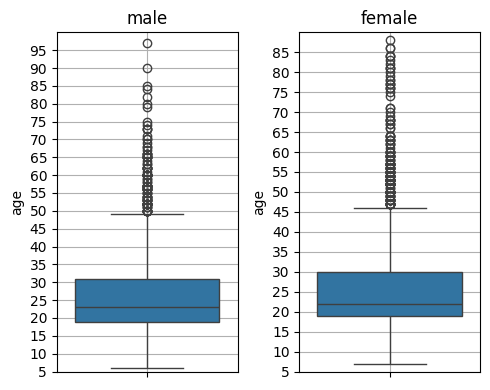

In [ ]:
dfe5, _ = get_cnt_without_cat(df, 5)
plot_age_dist(dfe5)

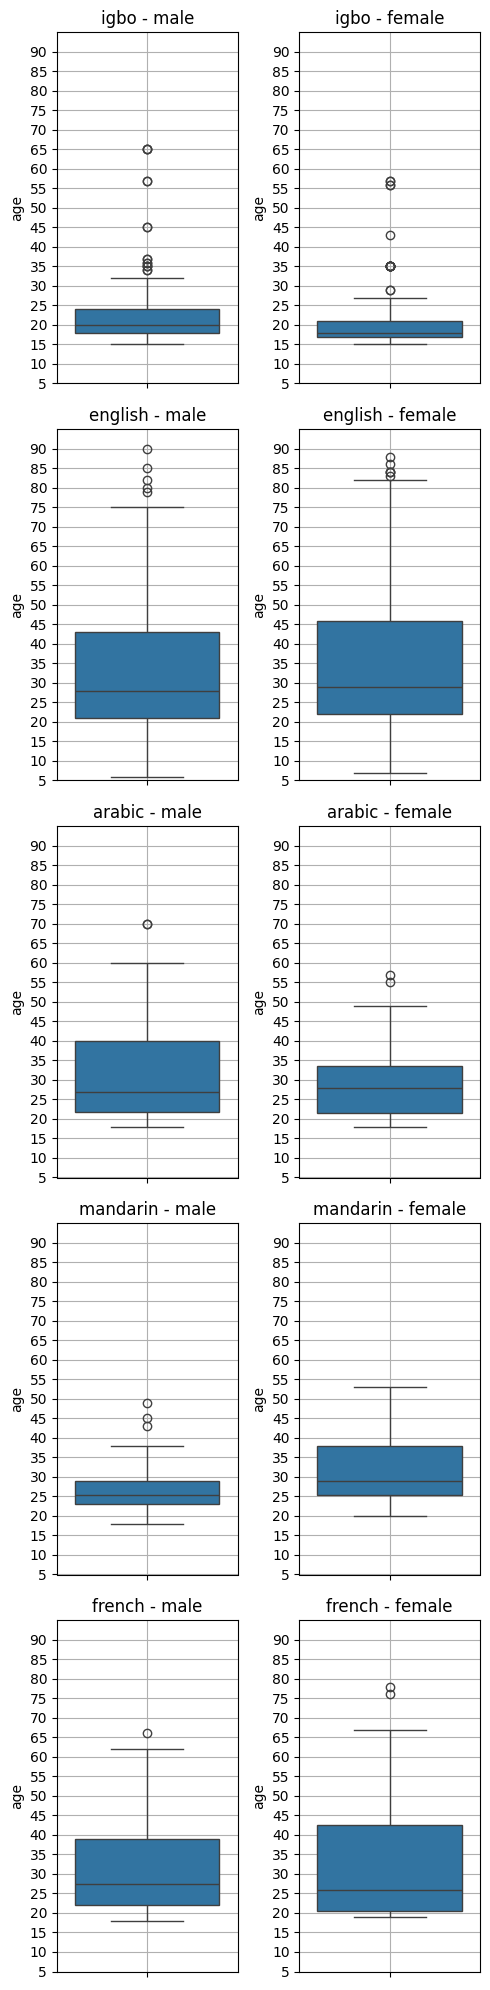

In [ ]:
plot_age_dist(df, 5, 'ethnicity')

In [ ]:
df_eth_encoded = cat_encoder(df, 'ethnicity', addAge=True)
df_eth_encoded

ethnicity_agni  ethnicity_akan  ethnicity_albanian  ethnicity_amazigh  \
0                0.0             0.0                 0.0                0.0   
1                0.0             0.0                 0.0                0.0   
2                0.0             0.0                 0.0                0.0   
3                0.0             0.0                 0.0                0.0   
4                0.0             0.0                 0.0                0.0   
...              ...             ...                 ...                ...   
2926             0.0             0.0                 0.0                0.0   
2927             0.0             0.0                 0.0                0.0   
2928             0.0             0.0                 0.0                0.0   
2929             0.0             0.0                 0.0                0.0   
2930             0.0             0.0                 0.0                0.0   

      ethnicity_amharic  ethnicity_annang  ethnicity_arabic  \
0                   0.0               0.0               1.0   
1                   0.0               0.0               0.0   
2                   0.0               0.0               0.0   
3                   0.0               0.0               0.0   
4                   0.0               0.0               0.0   
...                 ...               ...               ...   
2926                0.0               0.0               0.0   
2927                0.0               0.0               0.0   
2928                0.0               0.0               0.0   
2929                0.0               0.0               1.0   
2930                0.0               0.0               0.0   

      ethnicity_armenian  ethnicity_ashanti  ethnicity_azerbaijani  ...  \
0                    0.0                0.0                    0.0  ...   
1                    0.0                0.0                    0.0  ...   
2                    0.0                0.0                    0.0  ...   
3                    0.0                0.0                    0.0  ...   
4                    0.0                0.0                    0.0  ...   
...                  ...                ...                    ...  ...   
2926                 0.0                0.0                    0.0  ...   
2927                 0.0                0.0                    0.0  ...   
2928                 0.0                0.0                    0.0  ...   
2929                 0.0                0.0                    0.0  ...   
2930                 0.0                0.0                    0.0  ...   

      ethnicity_rwanda  ethnicity_sa'a  ethnicity_sardinian  ethnicity_sarua  \
0                  0.0             0.0                  0.0              0.0   
1                  0.0             0.0                  0.0              0.0   
2                  0.0             0.0                  0.0              0.0   
3                  0.0             0.0                  0.0              0.0   
4                  0.0             0.0                  0.0              0.0   
...                ...             ...                  ...              ...   
2926               0.0             0.0                  0.0              0.0   
2927               0.0             0.0                  0.0              0.0   
2928               0.0             0.0                  0.0              0.0   
2929               0.0             0.0                  0.0              0.0   
2930               0.0             0.0                  0.0              0.0   

      ethnicity_satawalese  ethnicity_tiv  ethnicity_ukwani  ethnicity_urhobo  \
0                      0.0            0.0               0.0               0.0   
1                      0.0            0.0               0.0               0.0   
2                      0.0            0.0               0.0               0.0   
3                      0.0            0.0               0.0               0.0   
4                      0.0       

<ipython-input-17-0324c8134c1c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dfc.index, y=dfc.values, palette=palette)


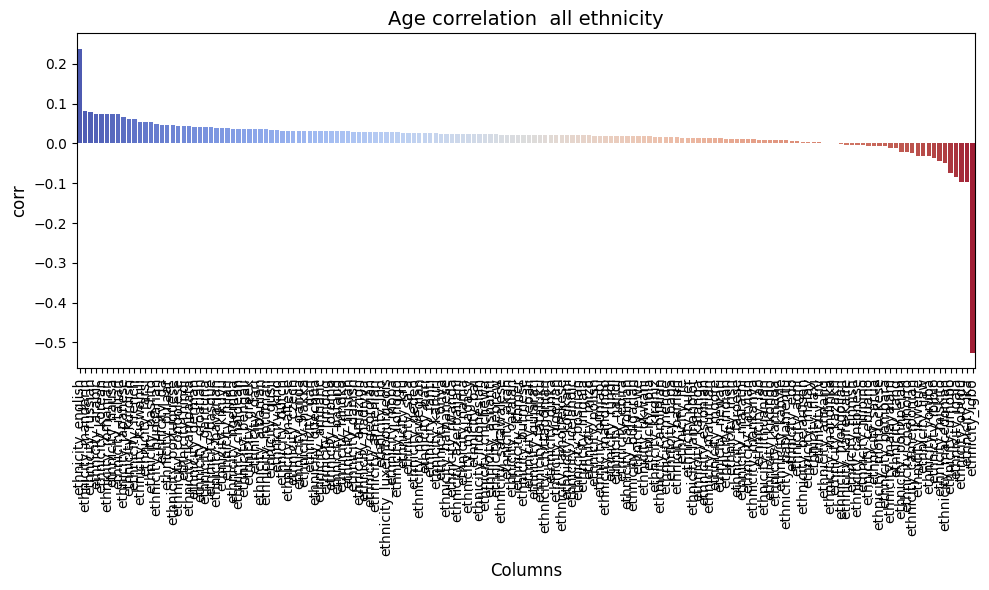

In [ ]:
df_corr = df_eth_encoded.corr(method='spearman')['age'].sort_values(ascending=False)
df_corr = df_corr.iloc[1:]
plot_corr(df_corr, header=' all ethnicity')

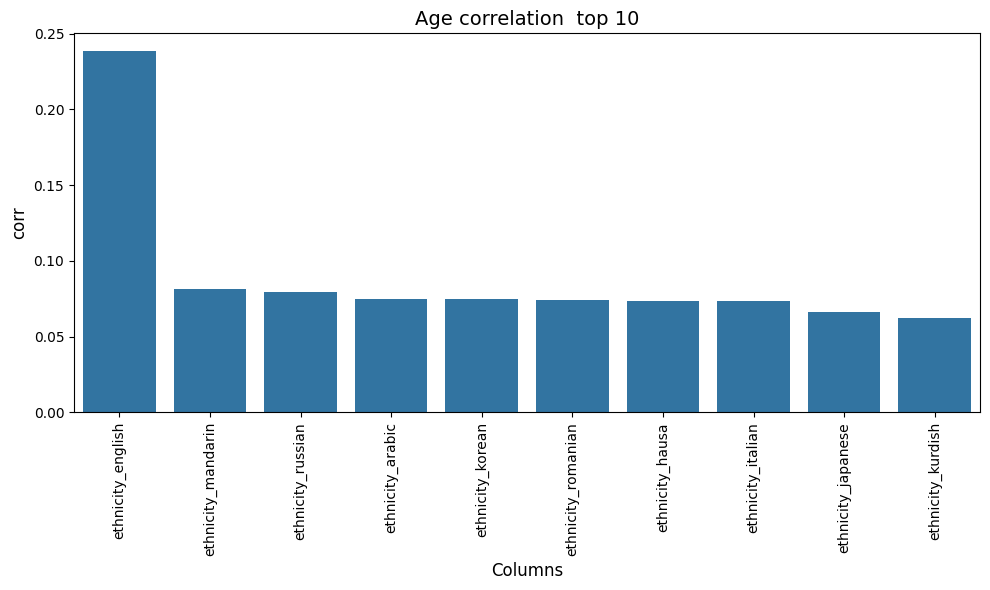

In [ ]:
plot_corr(df_corr, 'head', 10, ' top 10')

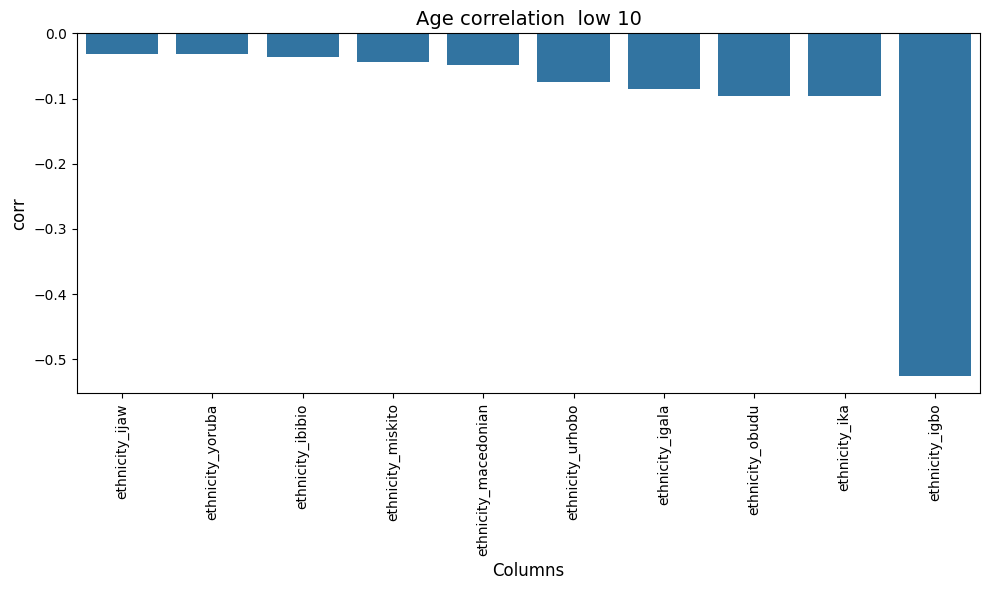

In [ ]:
plot_corr(df_corr, 'tail', 10, ' low 10')

In [ ]:
le_eth= LabelEncoder()

df['eth_encoded'] = le_eth.fit_transform(df['ethnicity'])
df

Id   age  gender   ethnicity  mean_pitch  max_pitch  min_pitch  \
0        0  24.0  female      arabic  1821.69060  3999.7170  145.43066   
1        1  22.5  female   hungarian  1297.81870  3998.8590  145.37268   
2        2  22.0  female  portuguese  1332.85240  3998.8025  145.42395   
3        3  22.0  female     english  1430.34990  3998.4510  147.98083   
4        4  22.0    male       dutch  1688.72340  3998.6113  145.44772   
...    ...   ...     ...         ...         ...        ...        ...   
2926  2928  24.0    male     english  1641.14930  3999.1616  145.39359   
2927  2929  15.0  female        igbo  1089.60050  3984.6550  145.58409   
2928  2930  17.0  female        igbo   994.46484  3989.1785  148.97475   
2929  2931  18.0    male      arabic  1600.00820  3999.7559  145.36101   
2930  2932  18.0  female        igbo   690.28046  3988.2874  149.26643   

        jitter   shimmer    energy  ...  spectral_centroid_mean       tempo  \
0     0.013795  0.082725  0.002254  ...             3112.257251  151.999081   
1     0.025349  0.096242  0.007819  ...             1688.016389  129.199219   
2     0.019067  0.119456  0.002974  ...             2576.901706  117.453835   
3     0.017004  0.102389  0.022371  ...             3269.751413  117.453835   
4     0.028027  0.124831  0.005369  ...             1930.897375  112.347147   
...        ...       ...       ...  ...                     ...         ...   
2926  0.023647  0.115361  0.001879  ...             2188.853478  184.570312   
2927  0.015317  0.126740  0.000339  ...             2712.362323   83.354335   
2928  0.009677  0.103535  0.001464  ...             2248.698477   89.102909   
2929  0.019571  0.100946  0.004451  ...             1834.596924  143.554688   
2930  0.014833  0.096168  0.003675  ...             1440.227098   83.354335   

             hnr  num_words  num_characters  num_pauses  silence_duration  \
0    -123.999726         69             281          39         23.846893   
1     -86.928478         69             281          21         19.388662   
2     -98.450670         69             281           1         21.640998   
3     -56.459762         69             281           9         19.644127   
4     -80.349204         69             281          11         18.041905   
...          ...        ...             ...         ...               ...   
2926 -100.921055         69             281          11         17.461406   
2927    6.757283          0               0           1          1.509206   
2928  -53.913449          1               9           1          1.645034   
2929  -96.143090         69             281          19         16.346848   
2930  -89.464755          0               0           4          2.275556   

                             path color eth_encoded  
0        audios_development/1.wav  pink           7  
1        audios_development/2.wav  pink          73  
2        audios_development/3.wav  pink         148  
3        audios_development/4.wav  pink          42  
4        audios_development/5.wav  blue          39  
...                           ...   ...         ...  
2926  audios_development/2929.wav  blue          42  
2927  audios_development/2930.wav  pink          78  
2928  audios_development/2931.wav  pink          78  
2929  audios_development/2932.wav  blue           7  
2930  audios_development/2933.wav  pink          78  

[2931 rows x 21 columns]

**gender**

In [ ]:
df['gender'].value_counts()

gender
female    1468
male      1463
Name: count, dtype: int64

In [ ]:
df_gen_encoded = cat_encoder(df, 'gender', addAge=True)
df_gen_encoded

gender_male   age
0             0.0  24.0
1             0.0  22.5
2             0.0  22.0
3             0.0  22.0
4             1.0  22.0
...           ...   ...
2926          1.0  24.0
2927          0.0  15.0
2928          0.0  17.0
2929          1.0  18.0
2930          0.0  18.0

[2931 rows x 2 columns]

<ipython-input-17-0324c8134c1c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dfc.index, y=dfc.values, palette=palette)


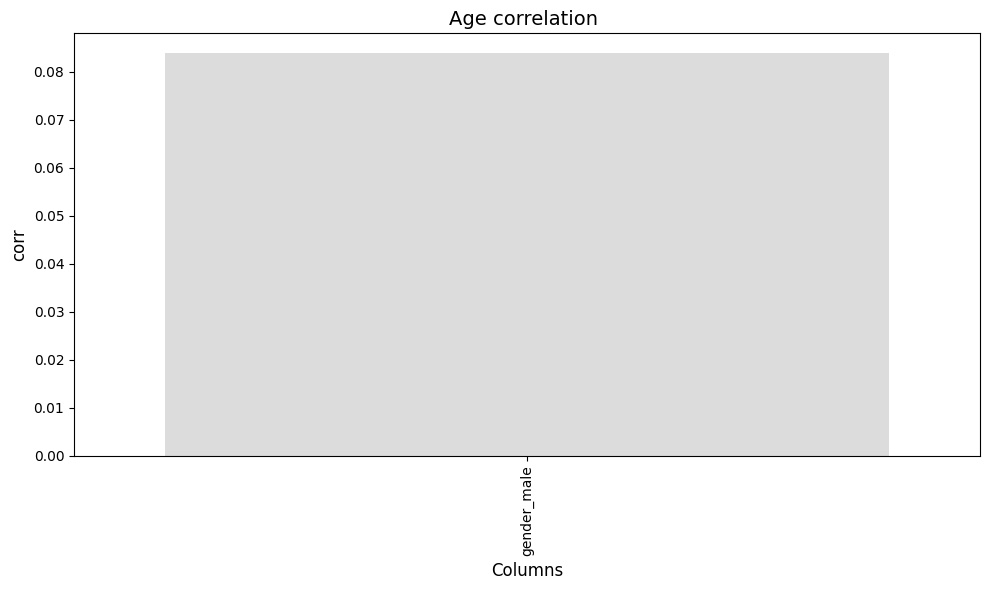

In [ ]:
df_corr = df_gen_encoded.corr(method='spearman')['age'].sort_values(ascending=False)
df_corr = df_corr.iloc[1:]
plot_corr(df_corr)

## Correlation

In [ ]:
col_filter = list(df.columns)
print(sorted(col_filter))

for c in ['path', 'Id', 'gender', 'ethnicity', 'color']:
    col_filter.remove(c)


print(sorted(col_filter))

['Id', 'age', 'color', 'energy', 'eth_encoded', 'ethnicity', 'gender', 'hnr', 'jitter', 'max_pitch', 'mean_pitch', 'min_pitch', 'num_characters', 'num_pauses', 'num_words', 'path', 'shimmer', 'silence_duration', 'spectral_centroid_mean', 'tempo', 'zcr_mean']
['age', 'energy', 'eth_encoded', 'hnr', 'jitter', 'max_pitch', 'mean_pitch', 'min_pitch', 'num_characters', 'num_pauses', 'num_words', 'shimmer', 'silence_duration', 'spectral_centroid_mean', 'tempo', 'zcr_mean']


In [ ]:
df.dtypes

Id                          int64
age                       float64
gender                     object
ethnicity                  object
mean_pitch                float64
max_pitch                 float64
min_pitch                 float64
jitter                    float64
shimmer                   float64
energy                    float64
zcr_mean                  float64
spectral_centroid_mean    float64
tempo                     float64
hnr                       float64
num_words                   int64
num_characters              int64
num_pauses                  int64
silence_duration          float64
path                       object
color                      object
eth_encoded                 int64
dtype: object

<ipython-input-17-0324c8134c1c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dfc.index, y=dfc.values, palette=palette)


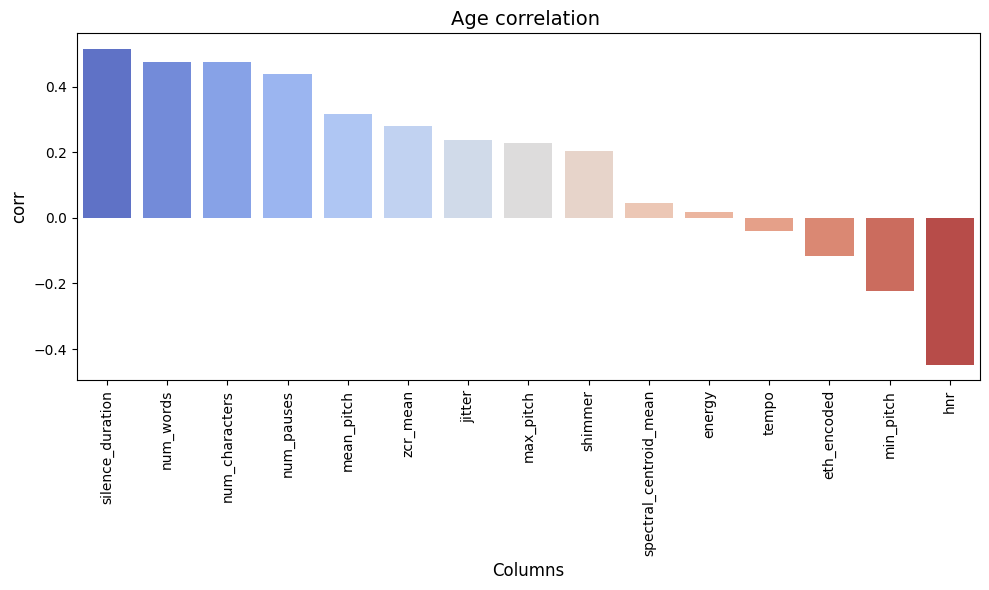

In [ ]:
df_corr = df[col_filter].corr()['age'].sort_values(ascending=False)
df_corr = df_corr.iloc[1:]
plot_corr(df_corr)

In [ ]:
col_filter.remove('eth_encoded')

<ipython-input-17-0324c8134c1c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dfc.index, y=dfc.values, palette=palette)


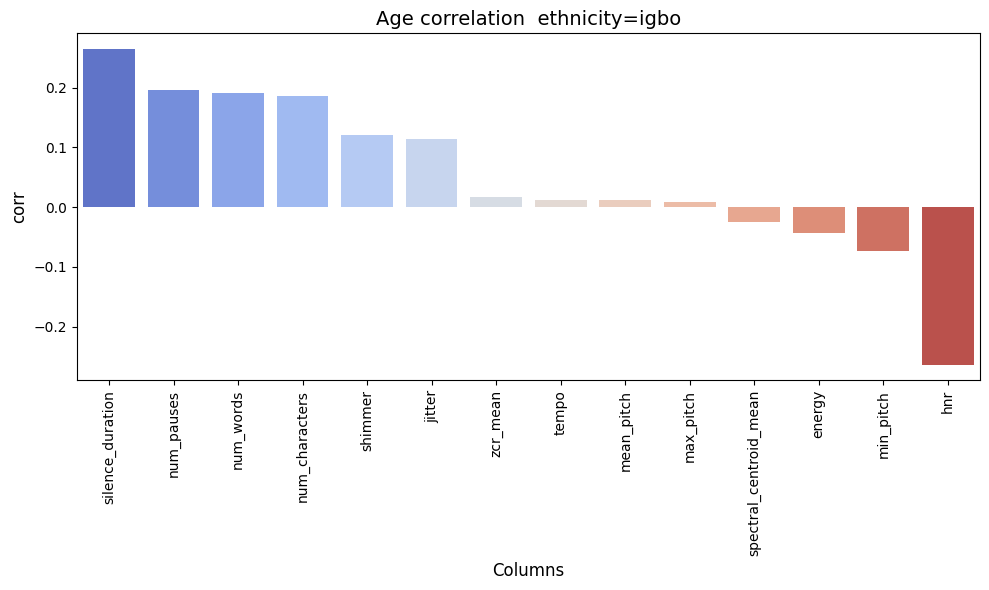

In [ ]:

df_corr = df[df['ethnicity'] == 'igbo'][col_filter].corr()['age'].sort_values(ascending=False)
df_corr = df_corr.iloc[1:]
plot_corr(df_corr, header=' ethnicity=igbo')

<ipython-input-17-0324c8134c1c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dfc.index, y=dfc.values, palette=palette)


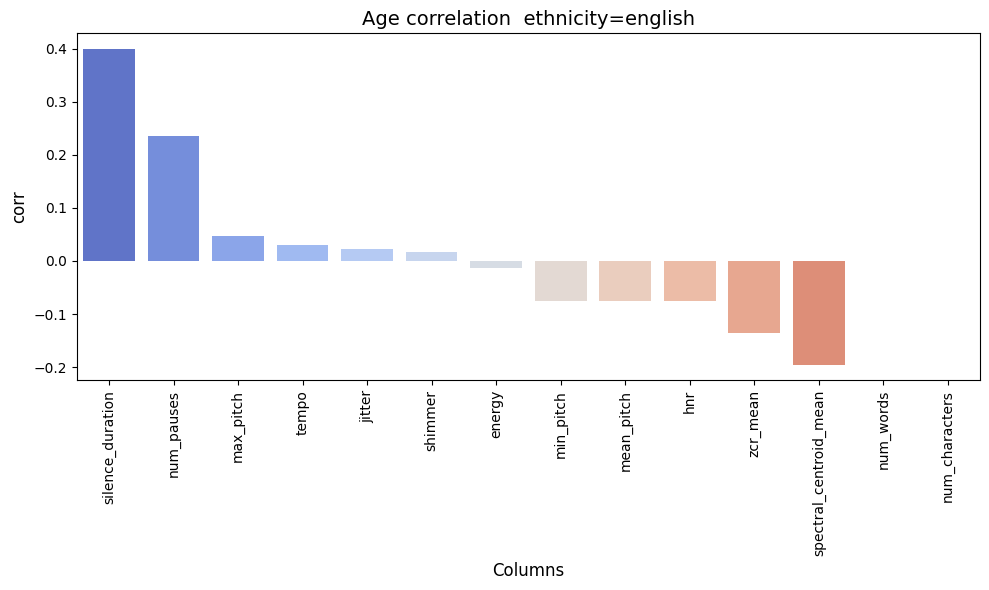

In [ ]:
df_corr = df[df['ethnicity'] == 'english'][col_filter].corr()['age'].sort_values(ascending=False)
df_corr = df_corr.iloc[1:]
plot_corr(df_corr, header=' ethnicity=english')

In [ ]:
corrs_res = []

for eth in df['ethnicity'].unique():
    # eth_res = defaultdict()
    df_corr = df[df['ethnicity'] == eth][col_filter].corr()['age'].fillna(0)
    eth_res = dict(zip(df_corr.index, df_corr.values))
    eth_res['ethnicity'] = eth
    corrs_res.append(eth_res)

In [ ]:
dfce = pd.DataFrame.from_records(corrs_res)
dfce

age  mean_pitch  max_pitch  min_pitch    jitter   shimmer    energy  \
0    1.0    0.260828   0.191163  -0.008340  0.022010 -0.040679 -0.067317   
1    1.0    0.508509  -0.022936  -0.150259  0.359119  0.578398  0.087249   
2    1.0    0.109104   0.150159   0.103665  0.235875  0.065493 -0.034571   
3    1.0   -0.074741   0.047630  -0.074671  0.022887  0.016575 -0.013834   
4    1.0   -0.242398   0.031147   0.229822  0.418169  0.405530  0.280799   
..   ...         ...        ...        ...       ...       ...       ...   
160  0.0    0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
161  0.0    0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
162  0.0    0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
163  0.0    0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
164  0.0    0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   

     zcr_mean  spectral_centroid_mean     tempo       hnr  num_words  \
0    0.136762                0.043246  0.074576 -0.222504        0.0   
1    0.741790                0.776755  0.104210  0.264379        0.0   
2   -0.129162               -0.244958 -0.212000 -0.310322        0.0   
3   -0.136041               -0.195171  0.029692 -0.075714        0.0   
4   -0.477108               -0.599828 -0.038785 -0.025107        0.0   
..        ...                     ...       ...       ...        ...   
160  0.000000                0.000000  0.000000  0.000000        0.0   
161  0.000000                0.000000  0.000000  0.000000        0.0   
162  0.000000                0.000000  0.000000  0.000000        0.0   
163  0.000000                0.000000  0.000000  0.000000        0.0   
164  0.000000                0.000000  0.000000  0.000000        0.0   

     num_characters  num_pauses  silence_duration   ethnicity  
0               0.0    0.294338          0.213643      arabic  
1               0.0    0.457214          0.711128   hungarian  
2               0.0    0.177262         -0.016125  portuguese  
3               0.0    0.235153          0.399237     english  
4               0.0    0.047596          0.402786       dutch  
..              ...         ...               ...         ...  
160             0.0    0.000000          0.000000       hakka  
161             0.0    0.000000          0.000000    malagasy  
162             0.0    0.000000          0.000000     lingala  
163             0.0    0.000000          0.000000        fang  
164             0.0    0.000000          0.000000       rundi  

[165 rows x 16 columns]

In [ ]:
eth_age_corr = dfce[dfce['age'] == 0]['ethnicity'].unique()
print(len(eth_age_corr), eth_age_corr)

68 ['nama' 'gan' 'ijaw' 'kanuri' 'baga' 'naxi' 'mizo' 'irish' 'agni' 'ika'
 'afemai' 'ikwerre' 'luxembourgeois' 'moore' 'kabyle' 'mankanya' "sa'a"
 'bai' 'konkani' 'ilonggo' 'newari' 'satawalese' 'mandinka' 'obudu' 'ife'
 'akan' 'mandingo' 'kaire-kaire' 'sarua' 'ukwani' 'lamotrekese' 'cebuano'
 'kru' 'fataluku' 'chichewa' 'kirghiz' 'sardinian' 'edo' 'carolinian'
 'annang' 'hindko' 'rwanda' 'kannada' 'moba' 'indian' 'jola' 'ebira'
 'pohnpeian' 'chamorro' 'frisian' 'gedeo' 'lamaholot' 'chittagonian'
 'ashanti' 'nandi' 'bamun' 'kalanga' 'hainanese' 'faroese' 'nuer'
 'cameroonian' 'dinka' 'mortlockese' 'hakka' 'malagasy' 'lingala' 'fang'
 'rundi']


In [ ]:
df[df['ethnicity'].isin(eth_age_corr)]['ethnicity'].nunique()

68

In [ ]:
dfce1 = dfce[dfce['age'] > 0]
dfce1

age  mean_pitch  max_pitch  min_pitch    jitter   shimmer    energy  \
0    1.0    0.260828   0.191163  -0.008340  0.022010 -0.040679 -0.067317   
1    1.0    0.508509  -0.022936  -0.150259  0.359119  0.578398  0.087249   
2    1.0    0.109104   0.150159   0.103665  0.235875  0.065493 -0.034571   
3    1.0   -0.074741   0.047630  -0.074671  0.022887  0.016575 -0.013834   
4    1.0   -0.242398   0.031147   0.229822  0.418169  0.405530  0.280799   
..   ...         ...        ...        ...       ...       ...       ...   
139  1.0    0.117424  -0.702009  -0.558405 -0.032680 -0.707114 -0.989377   
140  1.0    1.000000   1.000000  -1.000000 -1.000000  1.000000 -1.000000   
144  1.0   -0.464085  -0.647176  -0.126555  0.287003  0.418186  0.797668   
148  1.0   -1.000000  -1.000000   1.000000 -1.000000 -1.000000 -1.000000   
159  1.0    1.000000  -1.000000   1.000000 -1.000000 -1.000000  1.000000   

     zcr_mean  spectral_centroid_mean     tempo       hnr  num_words  \
0    0.136762                0.043246  0.074576 -0.222504        0.0   
1    0.741790                0.776755  0.104210  0.264379        0.0   
2   -0.129162               -0.244958 -0.212000 -0.310322        0.0   
3   -0.136041               -0.195171  0.029692 -0.075714        0.0   
4   -0.477108               -0.599828 -0.038785 -0.025107        0.0   
..        ...                     ...       ...       ...        ...   
139  0.219955                0.564899  0.559998 -0.891758        0.0   
140  1.000000                1.000000 -1.000000 -1.000000        0.0   
144 -0.755985               -0.950365  0.686500  0.672881        0.0   
148  1.000000                1.000000  0.000000 -1.000000        0.0   
159  1.000000                1.000000  1.000000  1.000000        0.0   

     num_characters  num_pauses  silence_duration   ethnicity  
0               0.0    0.294338          0.213643      arabic  
1               0.0    0.457214          0.711128   hungarian  
2               0.0    0.177262         -0.016125  portuguese  
3               0.0    0.235153          0.399237     english  
4               0.0    0.047596          0.402786       dutch  
..              ...         ...               ...         ...  
139             0.0    0.933257         -0.660707       fanti  
140             0.0   -1.000000         -1.000000   mauritian  
144             0.0    0.891751          0.370804   malayalam  
148             0.0    1.000000          1.000000    chaldean  
159             0.0    1.000000          1.000000     burmese  

[97 rows x 16 columns]

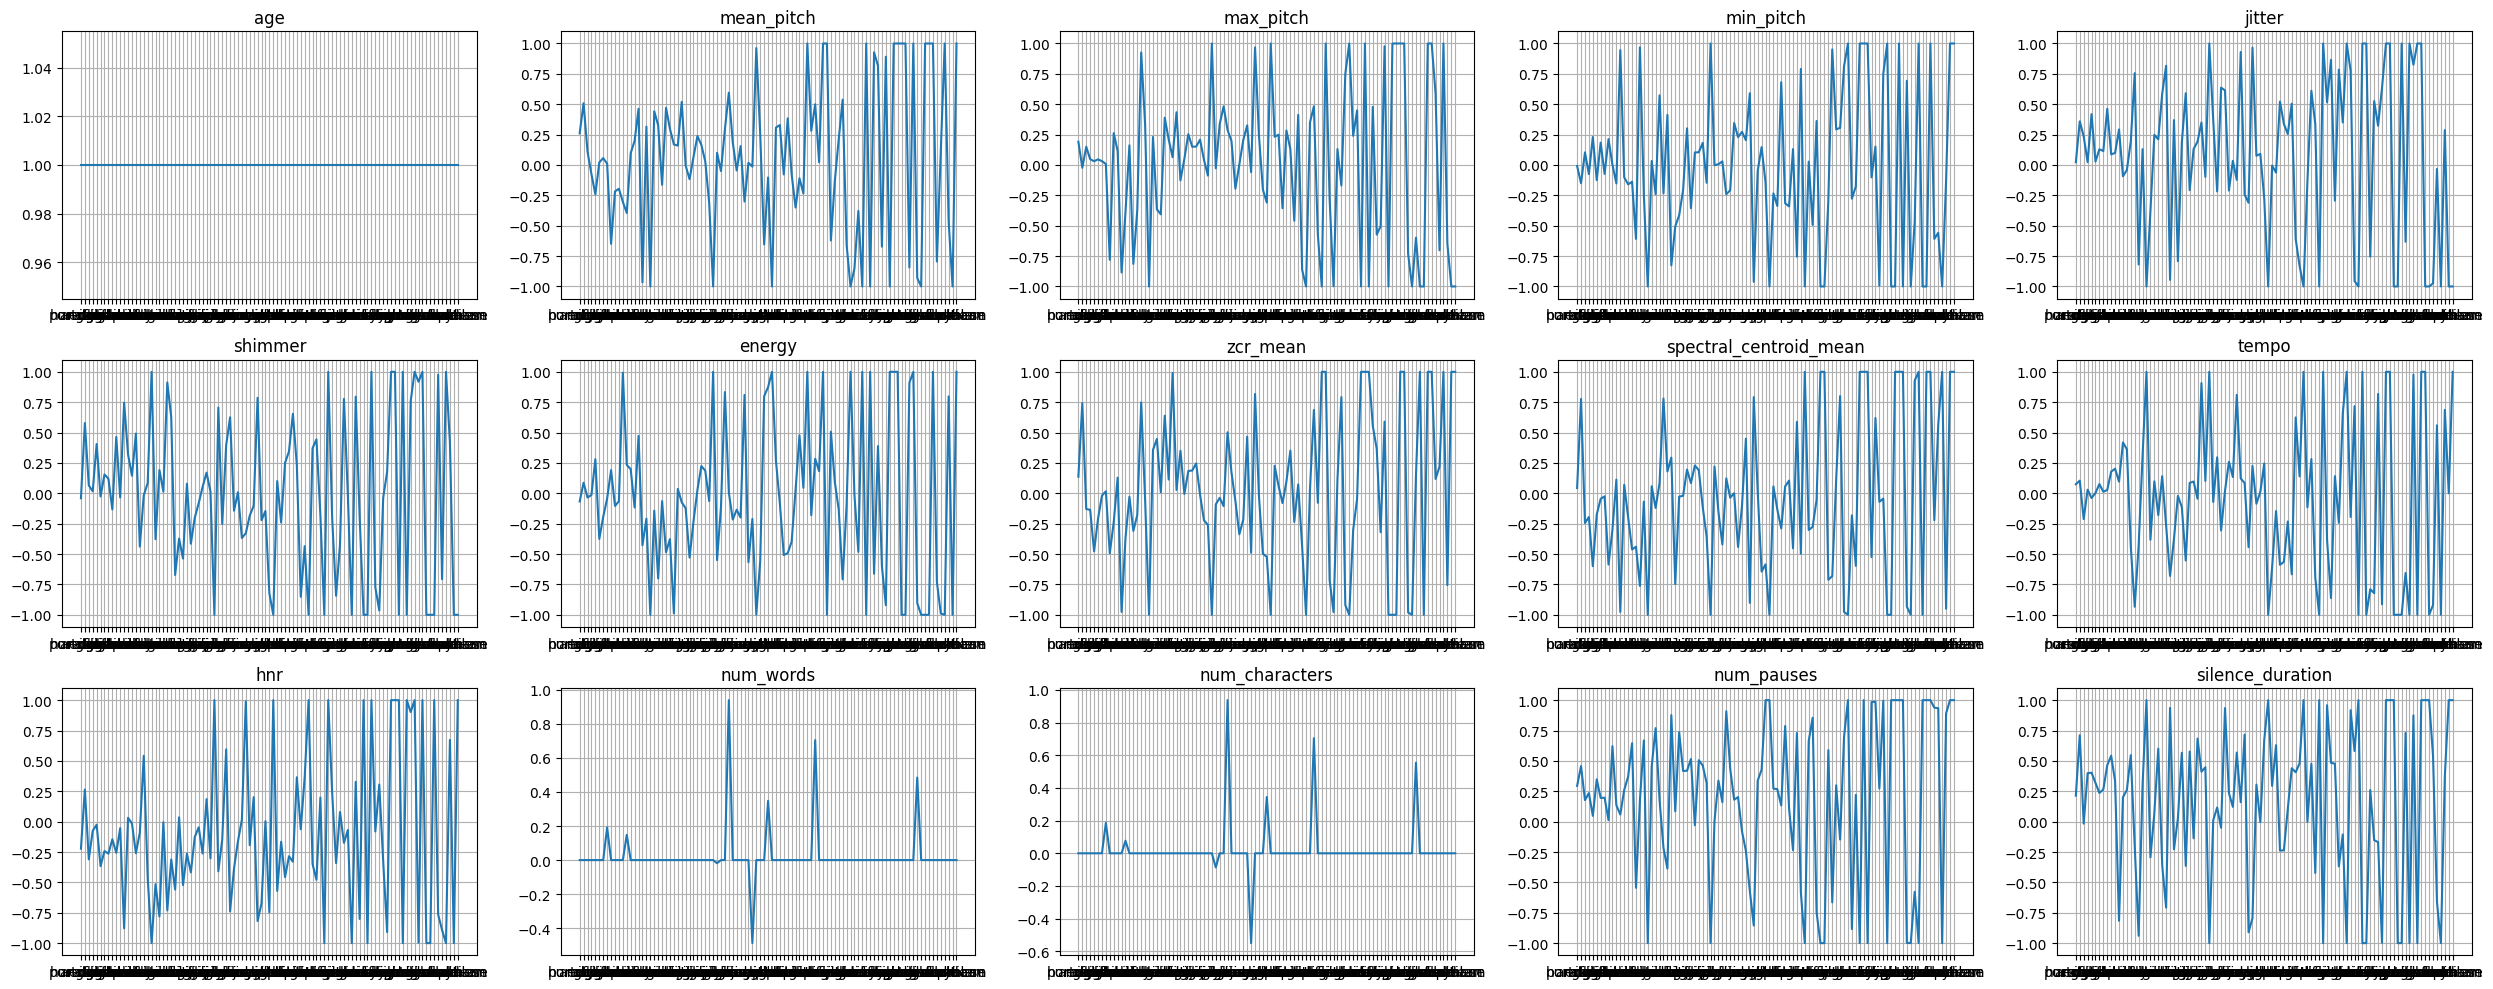

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(25, 10))

for i,c in enumerate(col_filter):
    axs[i // 5, i % 5].plot(dfce1['ethnicity'], dfce1[c])
    axs[i // 5, i % 5].set_title(f"{c}")
    axs[i // 5, i % 5].grid()


plt.tight_layout()
plt.show()

<ipython-input-17-0324c8134c1c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dfc.index, y=dfc.values, palette=palette)


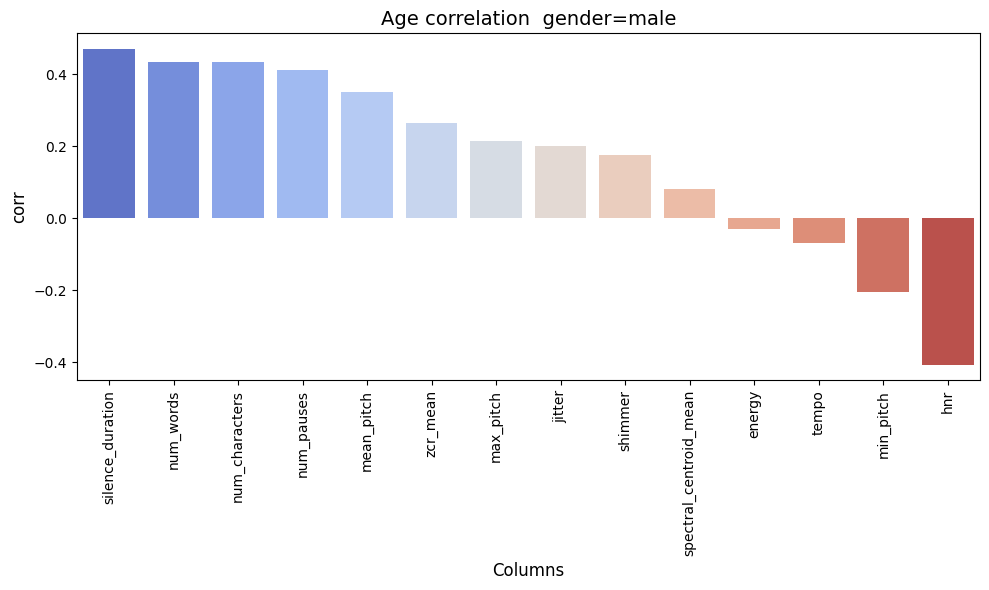

In [ ]:
df_corr = df[df['gender'] == 'male'][col_filter].corr()['age'].sort_values(ascending=False)
df_corr = df_corr.iloc[1:]
plot_corr(df_corr, header=' gender=male')

<ipython-input-17-0324c8134c1c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dfc.index, y=dfc.values, palette=palette)


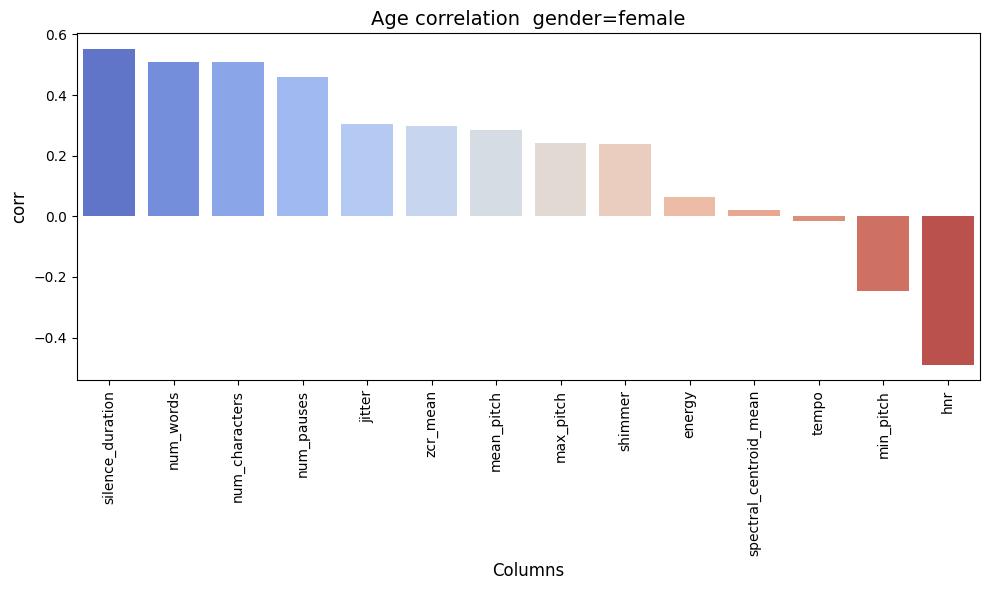

In [ ]:
df_corr = df[df['gender'] == 'female'][col_filter].corr()['age'].sort_values(ascending=False)
df_corr = df_corr.iloc[1:]
plot_corr(df_corr, header=' gender=female')

## Dependencies

In [ ]:
len(col_filter)

15

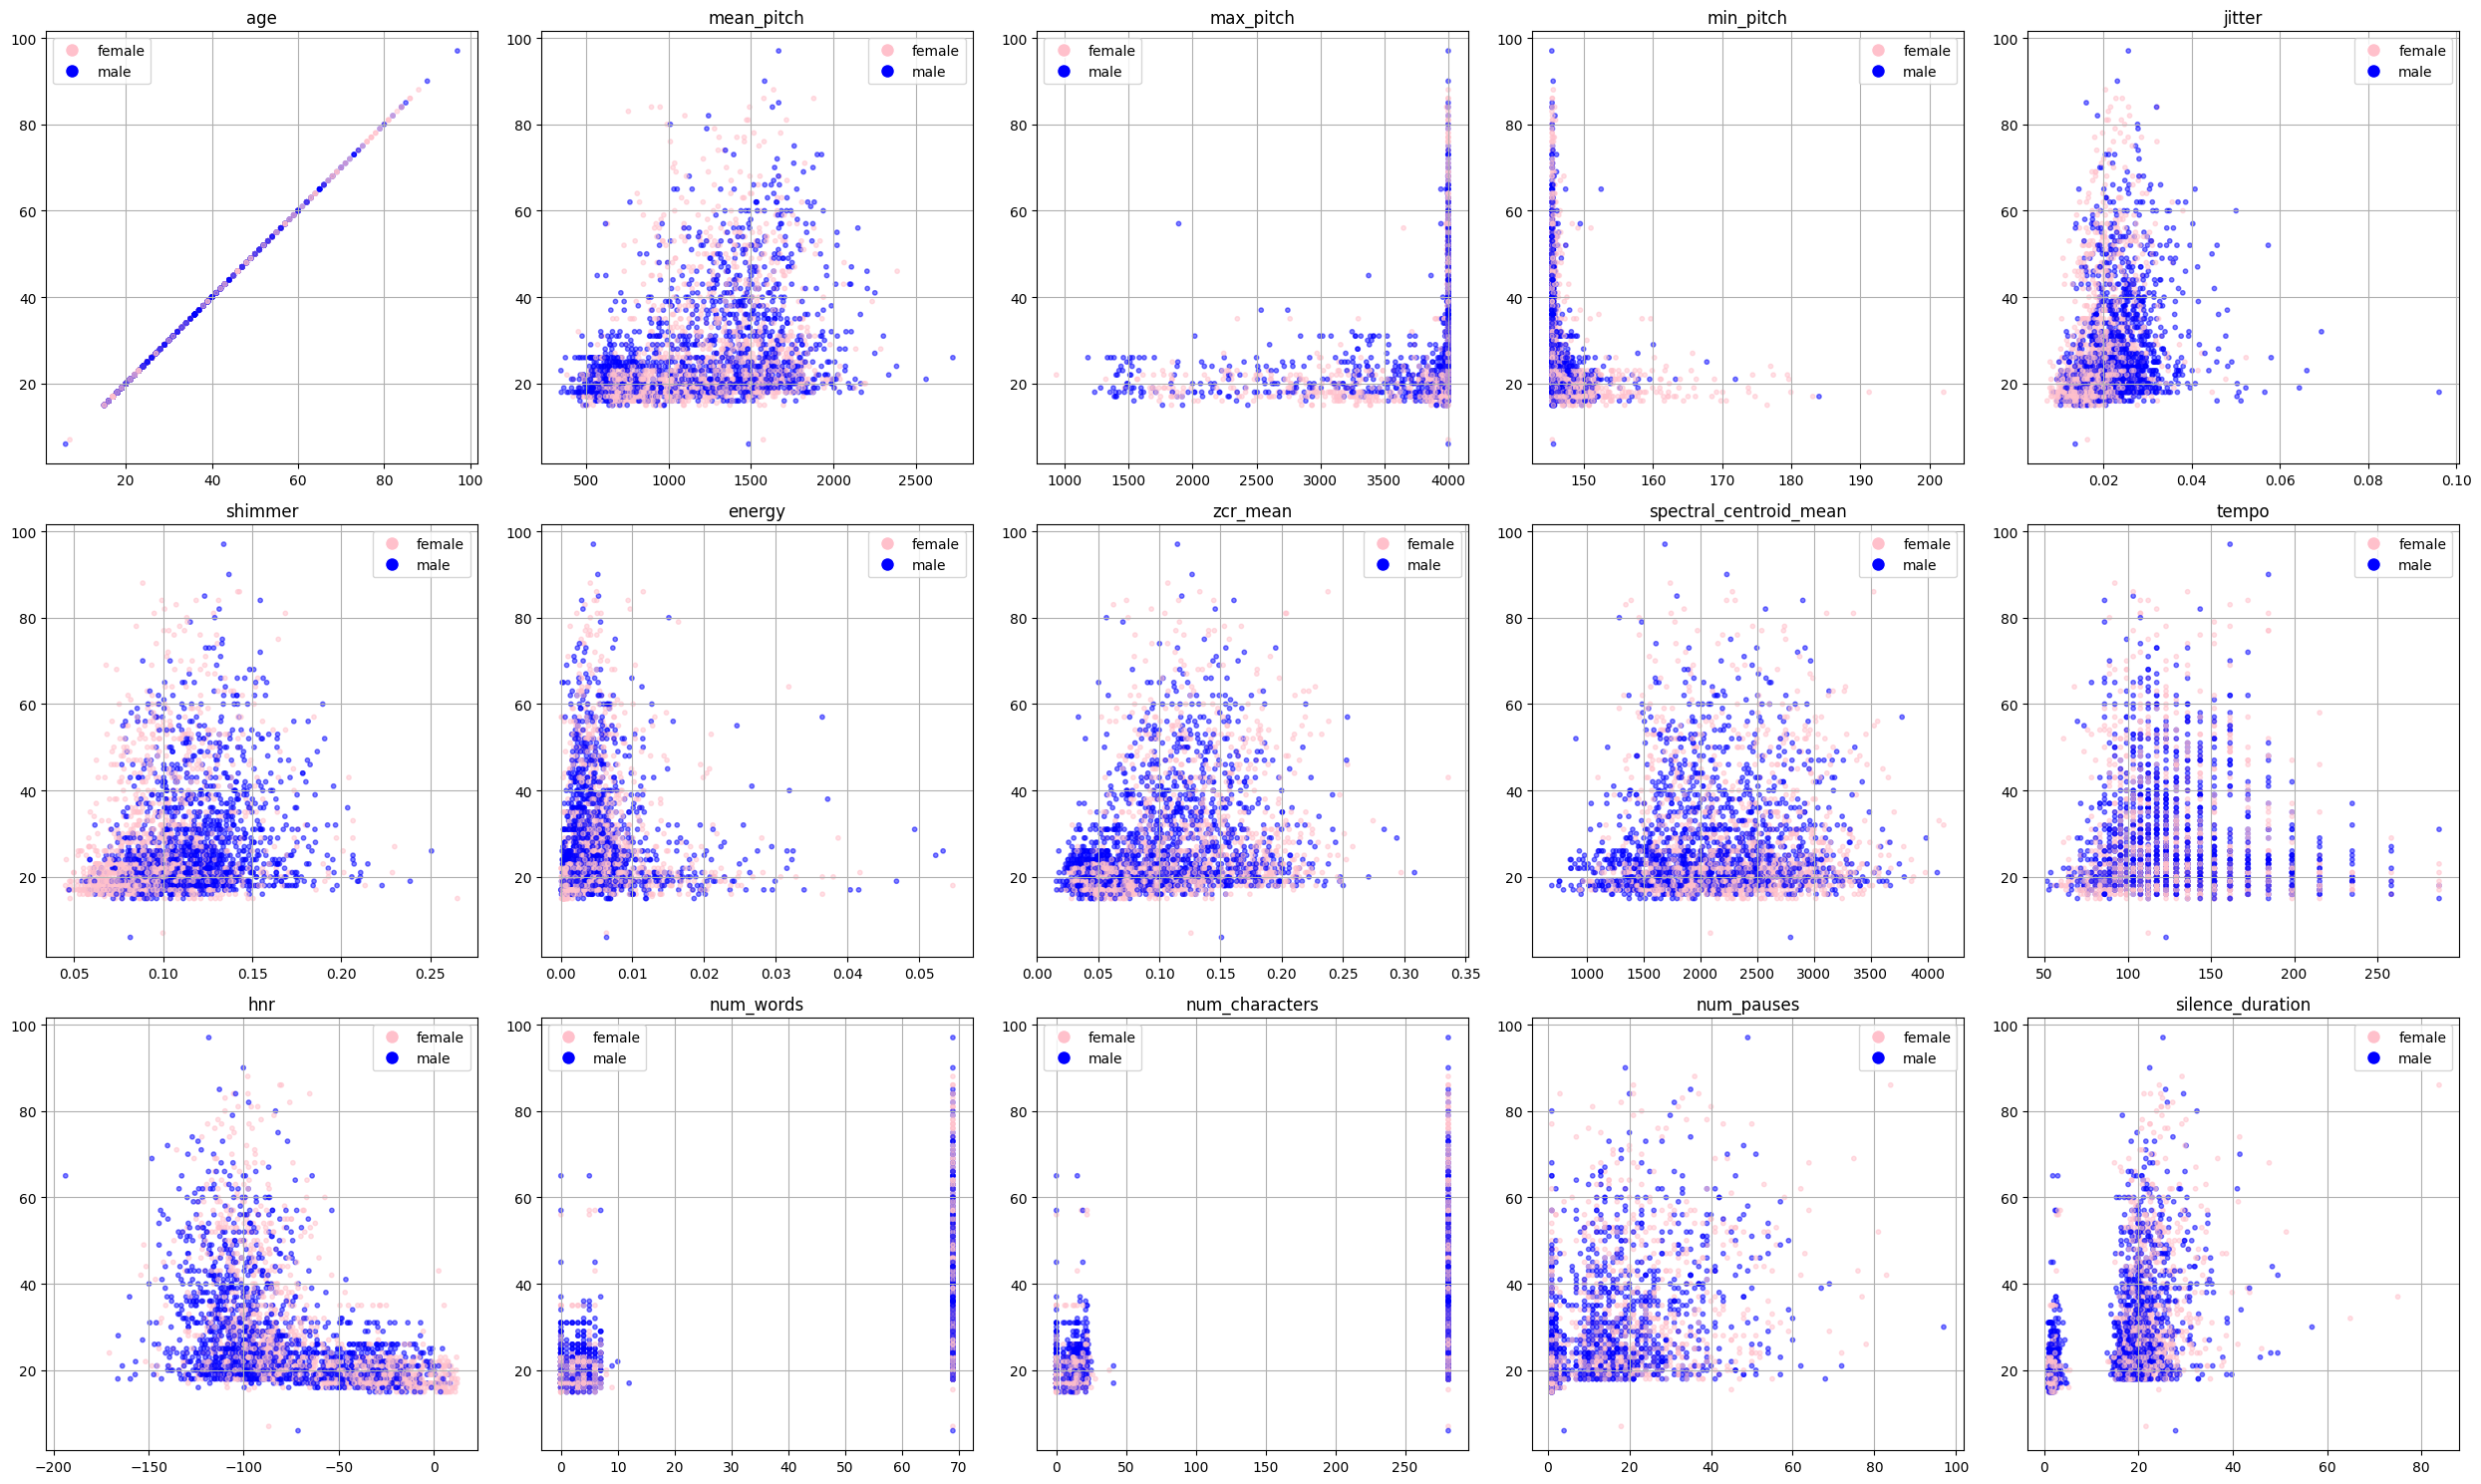

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(25, 15))

for i,c in enumerate(col_filter):
    axs[i // 5, i % 5].scatter(df[c], df['age'],alpha=0.5, s=10, c=df['gender'].map(color_map))
    axs[i // 5, i % 5].set_title(f"{c}")
    axs[i // 5, i % 5].grid()

    axs[i // 5, i % 5].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category)
                    for category, color in color_map.items()])

plt.tight_layout()
plt.show()


<ipython-input-63-d2741b3f163a>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  eth_category_colors = {category: color for category, color in zip(unique_categories, plt.cm.get_cmap('tab10', len(unique_categories)).colors)}


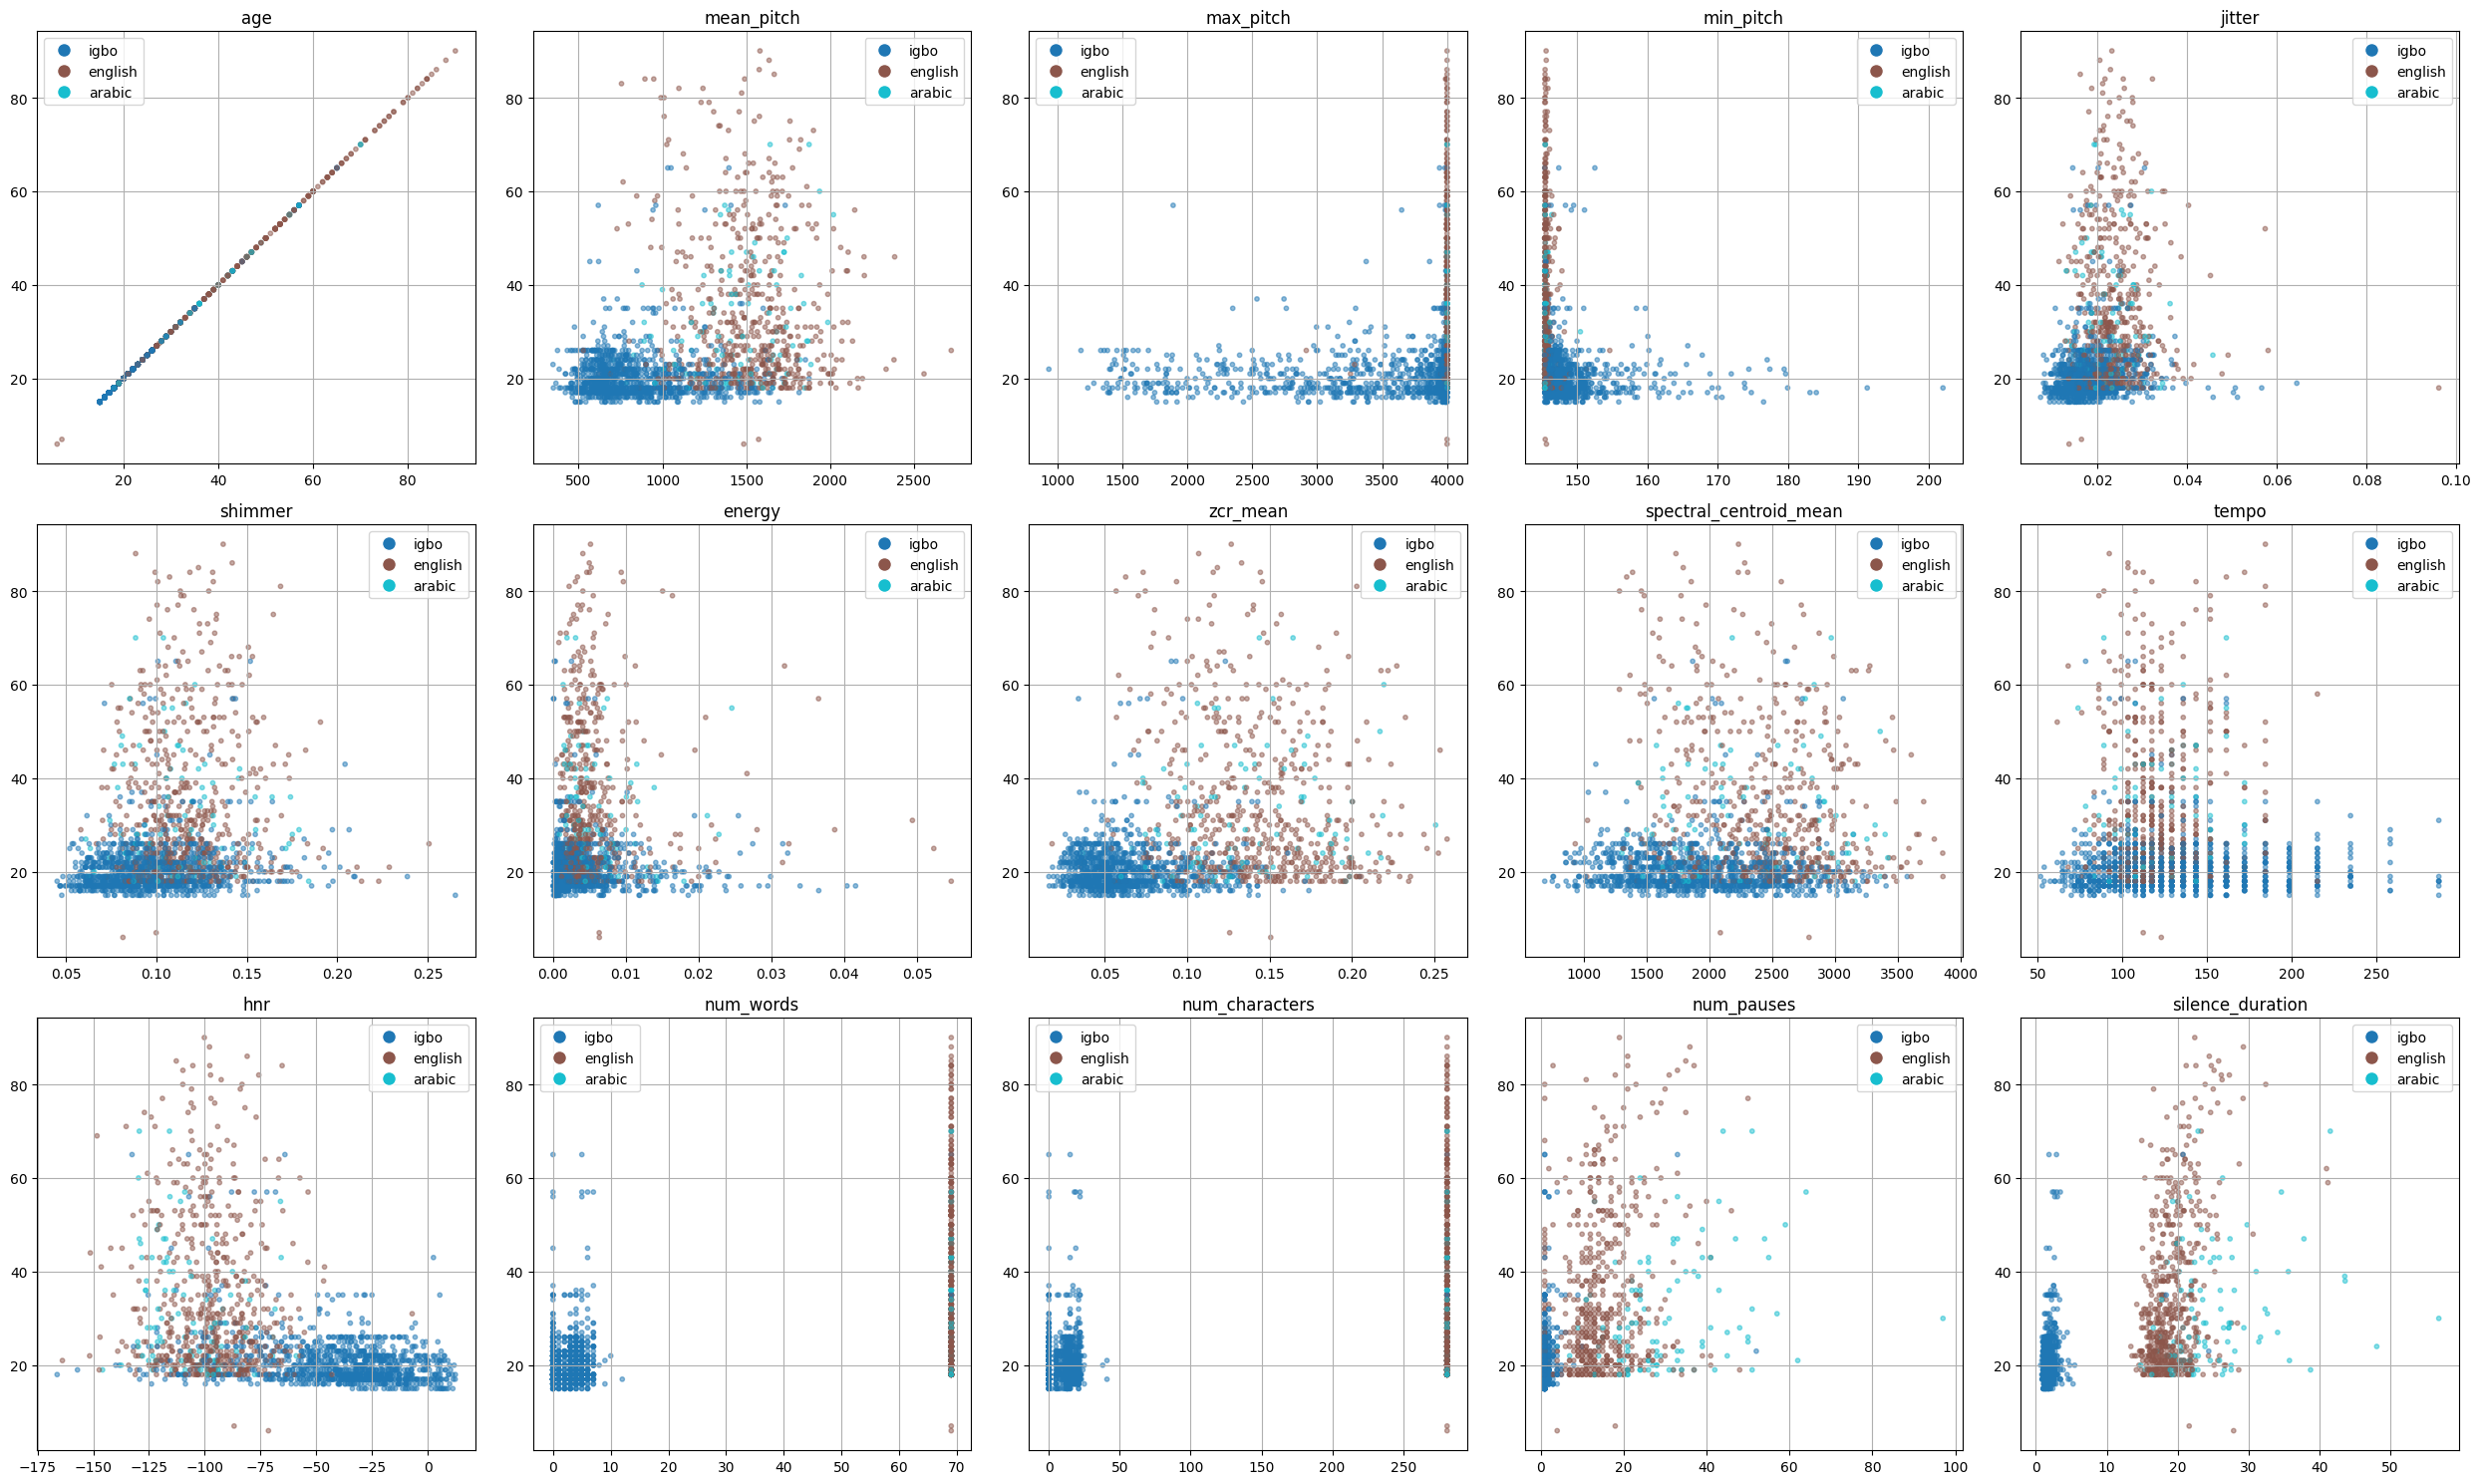

In [ ]:
unique_categories = df['ethnicity'].value_counts().index[0:3]
eth_category_colors = {category: color for category, color in zip(unique_categories, plt.cm.get_cmap('tab10', len(unique_categories)).colors)}

fig, axs = plt.subplots(3, 5, figsize=(25, 15))

dff = df[df['ethnicity'].isin(unique_categories)]

for i,c in enumerate(col_filter):
    axs[i // 5, i % 5].scatter(dff[c], dff['age'],alpha=0.5, s=10, c=dff['ethnicity'].map(eth_category_colors))
    axs[i // 5, i % 5].set_title(f"{c}")
    axs[i // 5, i % 5].grid()
    axs[i // 5, i % 5].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category)
                for category, color in eth_category_colors.items()])

plt.tight_layout()
plt.show()


# OH encoder for ethnicity

In [ ]:
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
oh_encoder.fit( df[['ethnicity']])

encoded_data = oh_encoder.transform(df[['ethnicity']])
encoded_df = pd.DataFrame(encoded_data, columns=oh_encoder.get_feature_names_out())

encoded_df

ethnicity_agni  ethnicity_akan  ethnicity_albanian  ethnicity_amazigh  \
0                0.0             0.0                 0.0                0.0   
1                0.0             0.0                 0.0                0.0   
2                0.0             0.0                 0.0                0.0   
3                0.0             0.0                 0.0                0.0   
4                0.0             0.0                 0.0                0.0   
...              ...             ...                 ...                ...   
2926             0.0             0.0                 0.0                0.0   
2927             0.0             0.0                 0.0                0.0   
2928             0.0             0.0                 0.0                0.0   
2929             0.0             0.0                 0.0                0.0   
2930             0.0             0.0                 0.0                0.0   

      ethnicity_amharic  ethnicity_annang  ethnicity_arabic  \
0                   0.0               0.0               1.0   
1                   0.0               0.0               0.0   
2                   0.0               0.0               0.0   
3                   0.0               0.0               0.0   
4                   0.0               0.0               0.0   
...                 ...               ...               ...   
2926                0.0               0.0               0.0   
2927                0.0               0.0               0.0   
2928                0.0               0.0               0.0   
2929                0.0               0.0               1.0   
2930                0.0               0.0               0.0   

      ethnicity_armenian  ethnicity_ashanti  ethnicity_azerbaijani  ...  \
0                    0.0                0.0                    0.0  ...   
1                    0.0                0.0                    0.0  ...   
2                    0.0                0.0                    0.0  ...   
3                    0.0                0.0                    0.0  ...   
4                    0.0                0.0                    0.0  ...   
...                  ...                ...                    ...  ...   
2926                 0.0                0.0                    0.0  ...   
2927                 0.0                0.0                    0.0  ...   
2928                 0.0                0.0                    0.0  ...   
2929                 0.0                0.0                    0.0  ...   
2930                 0.0                0.0                    0.0  ...   

      ethnicity_russian  ethnicity_rwanda  ethnicity_sa'a  \
0                   0.0               0.0             0.0   
1                   0.0               0.0             0.0   
2                   0.0               0.0             0.0   
3                   0.0               0.0             0.0   
4                   0.0               0.0             0.0   
...                 ...               ...             ...   
2926                0.0               0.0             0.0   
2927                0.0               0.0             0.0   
2928                0.0               0.0             0.0   
2929                0.0               0.0             0.0   
2930                0.0               0.0             0.0   

      ethnicity_sardinian  ethnicity_sarua  ethnicity_satawalese  \
0                     0.0              0.0                   0.0   
1                     0.0              0.0                   0.0   
2                     0.0              0.0                   0.0   
3                     0.0              0.0                   0.0   
4                     0.0              0.0                   0.0   
...                   ...              ...                   ...   
2926                  0.0              0.0                   0.0   
2927                  0.0              0.0                   0.0   
2928                  0.0              0.0            

# Train test split

In [ ]:
for col in ['age', 'num_words']:
    if col in col_filter:
        col_filter.remove(col)

In [ ]:
col_filter

['mean_pitch',
 'max_pitch',
 'min_pitch',
 'jitter',
 'shimmer',
 'energy',
 'zcr_mean',
 'spectral_centroid_mean',
 'tempo',
 'hnr',
 'num_characters',
 'num_pauses',
 'silence_duration']

In [ ]:
X = pd.concat([df[col_filter], encoded_df, cat_encoder(df, 'gender')], axis=1)
y = df['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (2344, 178) (2344,)
Test shape: (587, 178) (587,)


# Regression

In [ ]:
from datetime import datetime

In [ ]:
def learn_predict(mdl, X_train_f, y_train_f, X_test_f, y_test_f, dop=None, return_res=False):
    t0 = datetime.now()

    mdl.fit(X_train_f, y_train_f)

    y_pred = mdl.predict(X_test_f)

    rmse = np.sqrt(mean_squared_error(y_test_f, y_pred))
    mname = mdl.__class__.__name__

    secs = round((datetime.now() - t0).total_seconds(),2)
    print(f"{mname}, {dop if dop else ''}. RMSE:", round(rmse,3), 'time=',  secs)

    if return_res:
        return rmse, y_pred

    return {'model_name' : mname, 'time sec' : secs, 'RMSE' : rmse, 'comment' : dop}

In [ ]:
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 20, 100]

In [ ]:
errors = []

In [ ]:
def update_errors(p=3):
    dfr = pd.DataFrame.from_records(errors)
    dfr['RMSE_round'] = round(dfr['RMSE'],p)
    return dfr[dfr['RMSE_round'] == dfr['RMSE_round'].min()]

## Linear

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

r = learn_predict(model, X_train, y_train, X_test, y_test, 'no params')
errors.append(r)

LinearRegression, no params. RMSE: 10.549 time= 0.06


##. Ridge

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge(alpha=1.0)
r= learn_predict(model, X_train_scaled, y_train, X_test_scaled, y_test, 'scaled, a = 1')
errors.append(r)

Ridge, scaled, a = 1. RMSE: 10.414 time= 0.04


In [ ]:
alpha = 1.0

model = Ridge(alpha=alpha)
r = learn_predict(model, X_train, y_train, X_test, y_test, 'not scaled, a = 1')
errors.append(r)

Ridge, not scaled, a = 1. RMSE: 10.259 time= 0.04


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': alphas }
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)

grid_search.fit(X_train, y_train)
print("Best alpha:", grid_search.best_params_['alpha'])

Best alpha: 5


In [ ]:
for a in alphas:
    model = Ridge(alpha=a)
    r1 = learn_predict(model, X_train, y_train, X_test, y_test, f'not scaled a={a}')
    r2 = learn_predict(model, X_train_scaled, y_train, X_test_scaled, y_test, f'scaled a={a}')
    errors.append(r1)
    errors.append(r2)

Ridge, not scaled a=0.001. RMSE: 10.493 time= 0.14
Ridge, scaled a=0.001. RMSE: 10.549 time= 0.01
Ridge, not scaled a=0.01. RMSE: 10.369 time= 0.02
Ridge, scaled a=0.01. RMSE: 10.546 time= 0.02
Ridge, not scaled a=0.1. RMSE: 10.325 time= 0.02
Ridge, scaled a=0.1. RMSE: 10.52 time= 0.04
Ridge, not scaled a=1. RMSE: 10.259 time= 0.04
Ridge, scaled a=1. RMSE: 10.414 time= 0.02
Ridge, not scaled a=5. RMSE: 10.293 time= 0.09
Ridge, scaled a=5. RMSE: 10.369 time= 0.03
Ridge, not scaled a=10. RMSE: 10.335 time= 0.03
Ridge, scaled a=10. RMSE: 10.366 time= 0.02
Ridge, not scaled a=20. RMSE: 10.383 time= 0.02
Ridge, scaled a=20. RMSE: 10.368 time= 0.17
Ridge, not scaled a=100. RMSE: 10.499 time= 0.21
Ridge, scaled a=100. RMSE: 10.396 time= 0.25


## Lasso

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
for a in alphas:
    model = Lasso(alpha=a)
    r1 = learn_predict(model, X_train, y_train, X_test, y_test, f'not scaled a={a}')
    r2 = learn_predict(model, X_train_scaled, y_train, X_test_scaled, y_test, f'scaled a={a}')
    errors.append(r1)
    errors.append(r2)

Lasso, not scaled a=0.001. RMSE: 10.304 time= 0.37
Lasso, scaled a=0.001. RMSE: 10.367 time= 0.33
Lasso, not scaled a=0.01. RMSE: 10.25 time= 0.06
Lasso, scaled a=0.01. RMSE: 10.346 time= 0.35
Lasso, not scaled a=0.1. RMSE: 10.545 time= 0.06
Lasso, scaled a=0.1. RMSE: 10.335 time= 0.09
Lasso, not scaled a=1. RMSE: 10.805 time= 0.06
Lasso, scaled a=1. RMSE: 10.834 time= 0.02
Lasso, not scaled a=5. RMSE: 10.838 time= 0.05
Lasso, scaled a=5. RMSE: 12.283 time= 0.02
Lasso, not scaled a=10. RMSE: 10.944 time= 0.03
Lasso, scaled a=10. RMSE: 13.085 time= 0.01
Lasso, not scaled a=20. RMSE: 11.048 time= 0.02
Lasso, scaled a=20. RMSE: 13.085 time= 0.01
Lasso, not scaled a=100. RMSE: 11.236 time= 0.02
Lasso, scaled a=100. RMSE: 13.085 time= 0.02


## Elastic

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
# param_grid = {'alpha': alphas, 'l1_ratio' : np.arange(0.1, 1.1, 0.1) }
# grid_search = GridSearchCV(ElasticNet(), param_grid, cv=5)

# grid_search.fit(X_train, y_train)
# print("Best:", grid_search.best_params_)

In [ ]:
for a in alphas:
    for l1 in np.arange(0.1, 1.1, 0.1):
        model = ElasticNet(alpha=a, l1_ratio=l1)

        r = learn_predict(model, X_train, y_train, X_test, y_test, f'not scaled, alpha: {a}, l1_ratio: {l1}')
        errors.append(r)

        r = learn_predict(model, X_train_scaled, y_train, X_test_scaled, y_test, f'scaled, alpha: {a}, l1_ratio: {l1}')
        errors.append(r)

ElasticNet, not scaled, alpha: 0.001, l1_ratio: 0.1. RMSE: 10.261 time= 0.16


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.272e+04, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet, scaled, alpha: 0.001, l1_ratio: 0.1. RMSE: 10.378 time= 0.47
ElasticNet, not scaled, alpha: 0.001, l1_ratio: 0.2. RMSE: 10.259 time= 0.19


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e+04, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet, scaled, alpha: 0.001, l1_ratio: 0.2. RMSE: 10.377 time= 0.42
ElasticNet, not scaled, alpha: 0.001, l1_ratio: 0.30000000000000004. RMSE: 10.258 time= 0.18


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.366e+03, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet, scaled, alpha: 0.001, l1_ratio: 0.30000000000000004. RMSE: 10.376 time= 0.45
ElasticNet, not scaled, alpha: 0.001, l1_ratio: 0.4. RMSE: 10.256 time= 0.15


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.324e+03, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet, scaled, alpha: 0.001, l1_ratio: 0.4. RMSE: 10.375 time= 0.42
ElasticNet, not scaled, alpha: 0.001, l1_ratio: 0.5. RMSE: 10.255 time= 0.21


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.543e+03, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet, scaled, alpha: 0.001, l1_ratio: 0.5. RMSE: 10.374 time= 0.43
ElasticNet, not scaled, alpha: 0.001, l1_ratio: 0.6. RMSE: 10.255 time= 0.21


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.404e+03, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet, scaled, alpha: 0.001, l1_ratio: 0.6. RMSE: 10.372 time= 0.46
ElasticNet, not scaled, alpha: 0.001, l1_ratio: 0.7000000000000001. RMSE: 10.258 time= 0.2


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+03, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet, scaled, alpha: 0.001, l1_ratio: 0.7000000000000001. RMSE: 10.371 time= 0.42
ElasticNet, not scaled, alpha: 0.001, l1_ratio: 0.8. RMSE: 10.264 time= 0.23


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e+03, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet, scaled, alpha: 0.001, l1_ratio: 0.8. RMSE: 10.37 time= 0.43
ElasticNet, not scaled, alpha: 0.001, l1_ratio: 0.9. RMSE: 10.277 time= 0.26


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.415e+02, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet, scaled, alpha: 0.001, l1_ratio: 0.9. RMSE: 10.369 time= 0.43
ElasticNet, not scaled, alpha: 0.001, l1_ratio: 1.0. RMSE: 10.304 time= 0.35
ElasticNet, scaled, alpha: 0.001, l1_ratio: 1.0. RMSE: 10.367 time= 0.33
ElasticNet, not scaled, alpha: 0.01, l1_ratio: 0.1. RMSE: 10.391 time= 0.07
ElasticNet, scaled, alpha: 0.01, l1_ratio: 0.1. RMSE: 10.367 time= 0.15
ElasticNet, not scaled, alpha: 0.01, l1_ratio: 0.2. RMSE: 10.387 time= 0.07
ElasticNet, scaled, alpha: 0.01, l1_ratio: 0.2. RMSE: 10.366 time= 0.14
ElasticNet, not scaled, alpha: 0.01, l1_ratio: 0.30000000000000004. RMSE: 10.382 time= 0.06
ElasticNet, scaled, alpha: 0.01, l1_ratio: 0.30000000000000004. RMSE: 10.364 time= 0.13
ElasticNet, not scaled, alpha: 0.01, l1_ratio: 0.4. RMSE: 10.375 time= 0.06
ElasticNet, scaled, alpha: 0.01, l1_ratio: 0.4. RMSE: 10.362 time= 0.15
ElasticNet, not scaled, alpha: 0.01, l1_ratio: 0.5. RMSE: 10.369 time= 0.06
ElasticNet, scaled, alpha: 0.01, l1_ratio: 0.5. RMSE: 10.36 time= 0.14
Elasti

In [ ]:
update_errors()

model_name  time sec       RMSE                                 comment  \
21       Lasso      0.06  10.250269                       not scaled a=0.01   
73  ElasticNet      0.11  10.250269  not scaled, alpha: 0.01, l1_ratio: 1.0   

    RMSE_round  
21       10.25  
73       10.25

In [ ]:
from sklearn.feature_selection import RFE

model = Lasso(alpha=0.01)

for n_features in range(22, 32, 2):
    # selector = RFE(model, n_features_to_select=n_features)
    # X_train_selected = selector.fit_transform(X_train, y_train)
    # X_test_selected = selector.transform(X_test)

    # r = learn_predict(model, X_train_selected, y_train, X_test_selected, y_test, f'not scaled, selected={n_features}')
    # errors.append(r)

    selector = RFE(model, n_features_to_select=n_features)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    r = learn_predict(model, X_train_selected, y_train, X_test_selected, y_test, f'scaled, selected={n_features}')
    errors.append(r)

Lasso, scaled, selected=22. RMSE: 10.22 time= 0.0
Lasso, scaled, selected=24. RMSE: 10.219 time= 0.01
Lasso, scaled, selected=26. RMSE: 10.219 time= 0.02
Lasso, scaled, selected=28. RMSE: 10.166 time= 0.01
Lasso, scaled, selected=30. RMSE: 10.168 time= 0.01


In [ ]:
update_errors()

model_name  time sec       RMSE              comment  RMSE_round
198      Lasso      0.01  10.165838  scaled, selected=28      10.166

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

In [ ]:
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# selector = RFE(model, n_features_to_select=30)
# X_train_selected = selector.fit_transform(X_train_poly, y_train)
# X_test_selected = selector.transform(X_test_poly)

model = Lasso(alpha=0.01)
r= learn_predict(model, X_train_poly, y_train, X_test_poly, y_test, 'poly(2) on scaled, a = 0.01')
errors.append(r)

Lasso, poly(2) on scaled, a = 0.01. RMSE: 10.798 time= 23.98


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.975e+03, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
for a in alphas:
    model = Lasso(alpha=a)
    r= learn_predict(model, X_train_poly, y_train, X_test_poly, y_test, f'poly(2) on scaled, a = {a}')
    errors.append(r)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.147e+04, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


Lasso, poly(2) on scaled, a = 0.001. RMSE: 12.33 time= 24.82


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.975e+03, tolerance: 4.021e+01
  model = cd_fast.enet_coordinate_descent(


Lasso, poly(2) on scaled, a = 0.01. RMSE: 10.798 time= 25.23
Lasso, poly(2) on scaled, a = 0.1. RMSE: 10.103 time= 10.77
Lasso, poly(2) on scaled, a = 1. RMSE: 10.735 time= 1.24
Lasso, poly(2) on scaled, a = 5. RMSE: 12.36 time= 0.75
Lasso, poly(2) on scaled, a = 10. RMSE: 12.902 time= 0.64
Lasso, poly(2) on scaled, a = 20. RMSE: 13.022 time= 0.59
Lasso, poly(2) on scaled, a = 100. RMSE: 13.085 time= 0.53


In [ ]:
update_errors()

model_name  time sec       RMSE                     comment  RMSE_round
203      Lasso     10.77  10.102663  poly(2) on scaled, a = 0.1      10.103

In [ ]:
for a in [0.1]:
    for nf in range(28, 35, 1):
    # for nf in [25]:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selector', RFE( Lasso(alpha=a), n_features_to_select=nf)),
            ('poly', PolynomialFeatures(degree=2)),
            ('regressor', Lasso(alpha=a))
        ])

        r= learn_predict(pipeline, X_train, y_train, X_test, y_test, f'scale, select={nf}, poly=2, a={a}')
        errors.append(r)

Pipeline, scale, select=28, poly=2, a=0.1. RMSE: 9.877 time= 2.68
Pipeline, scale, select=29, poly=2, a=0.1. RMSE: 9.885 time= 2.73
Pipeline, scale, select=30, poly=2, a=0.1. RMSE: 9.88 time= 2.79
Pipeline, scale, select=31, poly=2, a=0.1. RMSE: 9.785 time= 3.36
Pipeline, scale, select=32, poly=2, a=0.1. RMSE: 9.787 time= 2.92
Pipeline, scale, select=33, poly=2, a=0.1. RMSE: 9.777 time= 2.78
Pipeline, scale, select=34, poly=2, a=0.1. RMSE: 9.802 time= 2.84


In [ ]:
update_errors()

model_name  time sec      RMSE                          comment  \
214   Pipeline      2.78  9.777084  scale, select=33, poly=2, a=0.1   

     RMSE_round  
214       9.777

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
model = RandomForestRegressor(random_state=42)

r= learn_predict(model, X_train, y_train, X_test, y_test, f'dafault, rs=42')
errors.append(r)

RandomForestRegressor, dafault, rs=42. RMSE: 10.27 time= 3.58


In [ ]:
model = RandomForestRegressor(random_state=42)

r= learn_predict(model, X_train_scaled, y_train, X_test_scaled, y_test, f'scaled, rs=42')
errors.append(r)

RandomForestRegressor, scaled, rs=42. RMSE: 10.275 time= 3.49


In [ ]:
%%time

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled, y_train)

print("Best params:", grid_search.best_params_)

Fitting 2 folds for each of 324 candidates, totalling 648 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils

Best params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
CPU times: user 4.92 s, sys: 437 ms, total: 5.36 s
Wall time: 4min 10s


In [ ]:
# Best params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

model = RandomForestRegressor(random_state=42, **grid_search.best_params_)

r= learn_predict(model, X_train_scaled, y_train, X_test_scaled, y_test, f'scaled, grid search 646, rs=42')
errors.append(r)

RandomForestRegressor, scaled, grid search 646, rs=42. RMSE: 10.128 time= 3.78


In [ ]:
best_params = {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state' : 42}

In [ ]:
feature_importances = model.feature_importances_

# Создаем DataFrame для отображения важности
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выводим важность признаков
importance_df.reset_index().head(20)

index                 Feature  Importance
0      12        silence_duration    0.117510
1      11              num_pauses    0.080769
2       9                     hnr    0.074805
3       1               max_pitch    0.071017
4       6                zcr_mean    0.067275
5       2               min_pitch    0.067226
6       0              mean_pitch    0.060303
7       3                  jitter    0.057966
8       4                 shimmer    0.056802
9       7  spectral_centroid_mean    0.056421
10      5                  energy    0.056371
11      8                   tempo    0.042955
12     10          num_characters    0.032751
13     90          ethnicity_igbo    0.028205
14     54       ethnicity_english    0.021400
15    177             gender_male    0.011854
16     65        ethnicity_french    0.004310
17     19        ethnicity_arabic    0.003936
18    159        ethnicity_polish    0.003554
19    167       ethnicity_russian    0.003122

In [ ]:
for bp in range(5, 150, 5):

    important_cols = importance_df.head(bp)['Feature'].to_list()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[important_cols])
    X_test_scaled = scaler.transform(X_test[important_cols])

    model = RandomForestRegressor(**best_params)
    r= learn_predict(model, X_train_scaled, y_train, X_test_scaled, y_test, f'scaled, grid search 646, best {bp}, rs=42')
    errors.append(r)

RandomForestRegressor, scaled, grid search 646, best 5, rs=42. RMSE: 11.016 time= 3.2
RandomForestRegressor, scaled, grid search 646, best 10, rs=42. RMSE: 10.671 time= 4.46
RandomForestRegressor, scaled, grid search 646, best 15, rs=42. RMSE: 10.192 time= 4.66
RandomForestRegressor, scaled, grid search 646, best 20, rs=42. RMSE: 10.151 time= 3.9
RandomForestRegressor, scaled, grid search 646, best 25, rs=42. RMSE: 10.155 time= 3.43
RandomForestRegressor, scaled, grid search 646, best 30, rs=42. RMSE: 10.165 time= 3.27
RandomForestRegressor, scaled, grid search 646, best 35, rs=42. RMSE: 10.157 time= 4.23
RandomForestRegressor, scaled, grid search 646, best 40, rs=42. RMSE: 10.12 time= 3.17
RandomForestRegressor, scaled, grid search 646, best 45, rs=42. RMSE: 10.128 time= 3.11
RandomForestRegressor, scaled, grid search 646, best 50, rs=42. RMSE: 10.126 time= 3.17
RandomForestRegressor, scaled, grid search 646, best 55, rs=42. RMSE: 10.099 time= 3.63
RandomForestRegressor, scaled, grid 

# Ansamble

In [ ]:
from sklearn.ensemble import  StackingRegressor

In [ ]:
alpha = 0.1
n_features = 33

lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', RFE(Lasso(alpha=a), n_features_to_select=nf)),
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso', Lasso(alpha=a))
])


In [ ]:
rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(**best_params))
])

In [ ]:
stacking_model = StackingRegressor(
    estimators=[('rf', rf), ('lasso', lasso)],
    final_estimator=LinearRegression()
)

# important_cols = importance_df.head()['Feature'].to_list()

r= learn_predict(stacking_model, X_train, y_train, X_test, y_test, f'Lasso + Forest, meta = Linear, all cols, rf not scaled')
errors.append(r)

StackingRegressor, Lasso + Forest, meta = Linear, all cols, rf not scaled. RMSE: 9.851 time= 28.52


In [ ]:
stacking_model = StackingRegressor(
    estimators=[('rf', rf), ('lasso', lasso)],
    final_estimator=Lasso(alpha=a)
)

important_cols = importance_df.head(95)['Feature'].to_list()

r= learn_predict(stacking_model, X_train[important_cols], y_train, X_test[important_cols], y_test, f'Lasso + Forest, meta = Lasso, only_important 95')
errors.append(r)

StackingRegressor, Lasso + Forest, meta = Lasso, only_important 95. RMSE: 9.828 time= 20.08


In [ ]:
stacking_model = StackingRegressor(
    estimators=[('rf', rf), ('lasso', lasso)],
    final_estimator=Ridge(alpha=a)
)

important_cols = importance_df.head(95)['Feature'].to_list()

r= learn_predict(stacking_model, X_train[important_cols], y_train, X_test[important_cols], y_test, f'Lasso + Forest, meta = Ridge, only_important 95')
errors.append(r)

StackingRegressor, Lasso + Forest, meta = Ridge, only_important 95. RMSE: 9.827 time= 20.61


# Submission

## Prepare

In [ ]:
dfev = pd.read_csv(f"{root_folder}/evaluation.csv")

In [ ]:
mapping = {
    'female' : 'female',
    'male' : 'male',
    'famale' : 'female'
}

dfev['gender'] = dfev['gender'].map(mapping)

In [ ]:
encoded_data_ev = oh_encoder.transform(dfev[['ethnicity']])
encoded_dfev = pd.DataFrame(encoded_data_ev, columns=oh_encoder.get_feature_names_out())
encoded_dfev

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ethnicity_agni  ethnicity_akan  ethnicity_albanian  ethnicity_amazigh  \
0               0.0             0.0                 0.0                0.0   
1               0.0             0.0                 0.0                0.0   
2               0.0             0.0                 0.0                0.0   
3               0.0             0.0                 0.0                0.0   
4               0.0             0.0                 0.0                0.0   
..              ...             ...                 ...                ...   
686             0.0             0.0                 0.0                0.0   
687             0.0             0.0                 0.0                0.0   
688             0.0             0.0                 0.0                0.0   
689             0.0             0.0                 0.0                0.0   
690             0.0             0.0                 0.0                0.0   

     ethnicity_amharic  ethnicity_annang  ethnicity_arabic  \
0                  0.0               0.0               0.0   
1                  0.0               0.0               0.0   
2                  0.0               0.0               0.0   
3                  0.0               0.0               0.0   
4                  0.0               0.0               0.0   
..                 ...               ...               ...   
686                0.0               0.0               0.0   
687                0.0               0.0               0.0   
688                0.0               0.0               0.0   
689                0.0               0.0               0.0   
690                0.0               0.0               0.0   

     ethnicity_armenian  ethnicity_ashanti  ethnicity_azerbaijani  ...  \
0                   0.0                0.0                    0.0  ...   
1                   0.0                0.0                    0.0  ...   
2                   0.0                0.0                    0.0  ...   
3                   0.0                0.0                    0.0  ...   
4                   0.0                0.0                    0.0  ...   
..                  ...                ...                    ...  ...   
686                 0.0                0.0                    0.0  ...   
687                 0.0                0.0                    0.0  ...   
688                 0.0                0.0                    0.0  ...   
689                 0.0                0.0                    0.0  ...   
690                 0.0                0.0                    0.0  ...   

     ethnicity_russian  ethnicity_rwanda  ethnicity_sa'a  ethnicity_sardinian  \
0                  0.0               0.0             0.0                  0.0   
1                  0.0               0.0             0.0                  0.0   
2                  0.0               0.0             0.0                  0.0   
3                  0.0               0.0             0.0                  0.0   
4                  0.0               0.0             0.0                  0.0   
..                 ...               ...             ...                  ...   
686                0.0               0.0             0.0                  0.0   
687                0.0               0.0             0.0                  0.0   
688                0.0               0.0             0.0                  0.0   
689                0.0               0.0             0.0                  0.0   
690                0.0               0.0             0.0                  0.0   

     ethnicity_sarua  ethnicity_satawalese  ethnicity_tiv  ethnicity_ukwani  \
0                0.0                   0.0            0.0               0.0   
1                0.0                   0.0            0.0               0.0   
2                0.0                   0.0            0.0               0.0   
3                0.0                   0.0            0.0               0.0   
4                0.0                   0.0            0.0         

In [ ]:
dfev['tempo'] = dfev['tempo'].str.strip("[]").str.split(", ").apply(lambda x: list(map(float, x)))

if type(list(dfev['tempo'])[0]) == list:
    dfev['tempo'] = dfev['tempo'].apply(lambda x: x[0])
if 'tempo_len' in dfev.columns:
    dfev.drop(columns=['tempo_len'], inplace=True)
dfev.describe()

Id  sampling_rate   mean_pitch    max_pitch   min_pitch  \
count  691.000000          691.0   691.000000   691.000000  691.000000   
mean   345.000000        22050.0  1191.041077  3832.214580  146.591685   
std    199.618803            0.0   379.826928   451.201809    3.212186   
min      0.000000        22050.0   419.396150  1151.012200  145.349230   
25%    172.500000        22050.0   865.617580  3955.649050  145.401825   
50%    345.000000        22050.0  1209.680400  3998.631300  145.529140   
75%    517.500000        22050.0  1487.326050  3999.521850  146.396920   
max    690.000000        22050.0  2201.411000  3999.790800  186.688950   

           jitter     shimmer      energy    zcr_mean  spectral_centroid_mean  \
count  691.000000  691.000000  691.000000  691.000000              691.000000   
mean     0.021320    0.110438    0.005074    0.105111             2214.701841   
std      0.006399    0.029365    0.005430    0.050162              571.250581   
min      0.009395    0.035001    0.000056    0.018496              803.534172   
25%      0.017184    0.089501    0.001851    0.064549             1785.536118   
50%      0.020670    0.106233    0.003582    0.098416             2174.406614   
75%      0.024536    0.126537    0.006147    0.135834             2580.589333   
max      0.077450    0.246068    0.048074    0.335676             4753.076563   

            tempo         hnr   num_words  num_characters  num_pauses  \
count  691.000000  691.000000  691.000000      691.000000  691.000000   
mean   126.437846  -84.551539   43.946454      178.522431   15.698987   
std     33.134285   36.514264   32.019084      130.933540   16.957466   
min     54.978391 -155.826124    0.000000        0.000000    1.000000   
25%    103.359375 -112.362377    5.000000       17.000000    1.000000   
50%    123.046875  -92.686476   69.000000      281.000000   11.000000   
75%    143.554688  -59.687405   69.000000      281.000000   26.000000   
max    258.398438   11.653742   69.000000      281.000000   76.000000   

       silence_duration  
count        691.000000  
mean          14.982523  
std           11.040405  
min            0.925669  
25%            2.115329  
50%           18.552744  
75%           23.010975  
max           57.663855

In [ ]:
dfprod = pd.concat([ dfev[col_filter],  encoded_dfev, cat_encoder(dfev, 'gender')], axis=1)
dfprod

mean_pitch  max_pitch  min_pitch    jitter   shimmer    energy  zcr_mean  \
0    1056.91740  3945.1610  145.38750  0.022082  0.171076  0.003136  0.032963   
1    1231.84570  3999.1720  145.56432  0.026571  0.132585  0.006783  0.123895   
2     958.29065  3445.4490  145.67374  0.018044  0.096289  0.004478  0.089149   
3    1396.54170  3998.8948  145.41223  0.027290  0.088901  0.014893  0.097054   
4    1633.86770  3999.7632  145.36313  0.021621  0.103855  0.001369  0.140950   
..          ...        ...        ...       ...       ...       ...       ...   
686   570.62740  3900.6730  145.67577  0.018842  0.079197  0.004545  0.072083   
687   974.13965  3919.0024  145.90408  0.024367  0.117492  0.000878  0.076900   
688  1113.27650  3999.3510  145.38307  0.020637  0.089355  0.009148  0.095613   
689  1759.17420  3999.4610  145.56773  0.026118  0.106429  0.003707  0.141474   
690   779.53890  3972.4630  147.44424  0.010952  0.108114  0.003370  0.083540   

     spectral_centroid_mean       tempo         hnr  ...  ethnicity_rwanda  \
0               1549.607050   80.749512 -116.662338  ...               0.0   
1               2344.817369   89.102909  -78.253824  ...               0.0   
2               1939.574896  123.046875  -71.630742  ...               0.0   
3               1832.059113  123.046875 -101.533013  ...               0.0   
4               2534.611168  112.347147 -134.914070  ...               0.0   
..                      ...         ...         ...  ...               ...   
686             1946.502158  112.347147  -42.895295  ...               0.0   
687             3319.620800  112.347147 -144.881089  ...               0.0   
688             1973.127197  112.347147  -73.559944  ...               0.0   
689             2137.517812  117.453835  -93.562873  ...               0.0   
690             2530.285199  184.570312  -35.776665  ...               0.0   

     ethnicity_sa'a  ethnicity_sardinian  ethnicity_sarua  \
0               0.0                  0.0              0.0   
1               0.0                  0.0              0.0   
2               0.0                  0.0              0.0   
3               0.0                  0.0              0.0   
4               0.0                  0.0              0.0   
..              ...                  ...              ...   
686             0.0                  0.0              0.0   
687             0.0                  0.0              0.0   
688             0.0                  0.0              0.0   
689             0.0                  0.0              0.0   
690             0.0                  0.0              0.0   

     ethnicity_satawalese  ethnicity_tiv  ethnicity_ukwani  ethnicity_urhobo  \
0                     0.0            0.0               0.0               0.0   
1                     0.0            0.0               0.0               0.0   
2                     0.0            0.0               0.0               0.0   
3                     0.0            0.0               0.0               0.0   
4                     0.0            0.0               0.0               0.0   
..                    ...            ...               ...               ...   
686                   0.0            0.0               0.0               0.0   
687                   0.0            0.0               0.0               0.0   
688                   0.0            0.0               0.0               0.0   
689                   0.0            0.0               0.0               0.0   
690                   0.0            0.0               0.0               0.0   

     ethnicity_yoruba  gender_male  
0                 0.0          1.0  
1                 0.0          1.0  
2                 0.0          1.0  
3                 0.0          0.0  
4                 0.0          1.0  
..                ...          ...  
686               0.0          1.0  
687               0.0          1.0  
688               0.0          0.0  
689               0.0          

## Lasso regression

In [ ]:
alpha = 0.1
n_features = 33

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', RFE( Lasso(alpha=a), n_features_to_select=nf)),
    ('poly', PolynomialFeatures(degree=2)),
    ('regressor', Lasso(alpha=a))
])

pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 RFE(estimator=Lasso(alpha=0.1), n_features_to_select=34)),
                ('poly', PolynomialFeatures()),
                ('regressor', Lasso(alpha=0.1))])

In [ ]:
y_pred = pipeline.predict(dfprod)

df_predicted =  pd.DataFrame( {'Id' : dfev['Id'], 'Predicted' : y_pred } )

df_predicted.to_csv('V2.csv', index=False)

df_predicted

# submited, score = 9.987

Id  Predicted
0      0  26.987975
1      1  37.730374
2      2  22.594862
3      3  37.625630
4      4  36.683744
..   ...        ...
686  686  21.920968
687  687  24.548931
688  688  30.356065
689  689  31.769568
690  690  20.497680

[691 rows x 2 columns]

In [ ]:
from google.colab import files
files.download('V3.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ansamble Lasso + Forest

In [ ]:
alpha = 0.1
n_features = 33

lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', RFE( Lasso(alpha=a), n_features_to_select=nf)),
    ('poly', PolynomialFeatures(degree=2)),
    ('regressor', Lasso(alpha=a))
])


rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(**best_params))
])

stacking_model = StackingRegressor(
    estimators=[('rf', rf), ('lasso', lasso)],
    final_estimator=LinearRegression()
)

important_cols = importance_df.head()['Feature'].to_list()

stacking_model.fit(X[important_cols], y)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=34 > n_features=5. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=34 > n_features=5. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=34 > n_features=5. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=34 > n_features=5. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_sele

StackingRegressor(estimators=[('rf',
                               Pipeline(steps=[('scaler', StandardScaler()),
                                               ('rf',
                                                RandomForestRegressor(max_depth=30,
                                                                      max_features='log2',
                                                                      n_estimators=500,
                                                                      random_state=42))])),
                              ('lasso',
                               Pipeline(steps=[('scaler', StandardScaler()),
                                               ('selector',
                                                RFE(estimator=Lasso(alpha=0.1),
                                                    n_features_to_select=34)),
                                               ('poly', PolynomialFeatures()),
                                               ('regressor',
                                                Lasso(alpha=0.1))]))],
                  final_estimator=LinearRegression())

In [ ]:
y_pred = stacking_model.predict(dfprod[important_cols])

df_predicted =  pd.DataFrame( {'Id' : dfev['Id'], 'Predicted' : y_pred } )

df_predicted.to_csv('V3.csv', index=False)

df_predicted

# submited, score = 10.433

Id  Predicted
0      0  32.402568
1      1  37.439909
2      2  22.729194
3      3  35.387443
4      4  39.956952
..   ...        ...
686  686  20.996882
687  687  26.107504
688  688  34.578333
689  689  32.137827
690  690  20.369617

[691 rows x 2 columns]